In [27]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import shutil

1/1 [==============================] - 0s 252ms/step


(-0.5, 226.5, 226.5, -0.5)

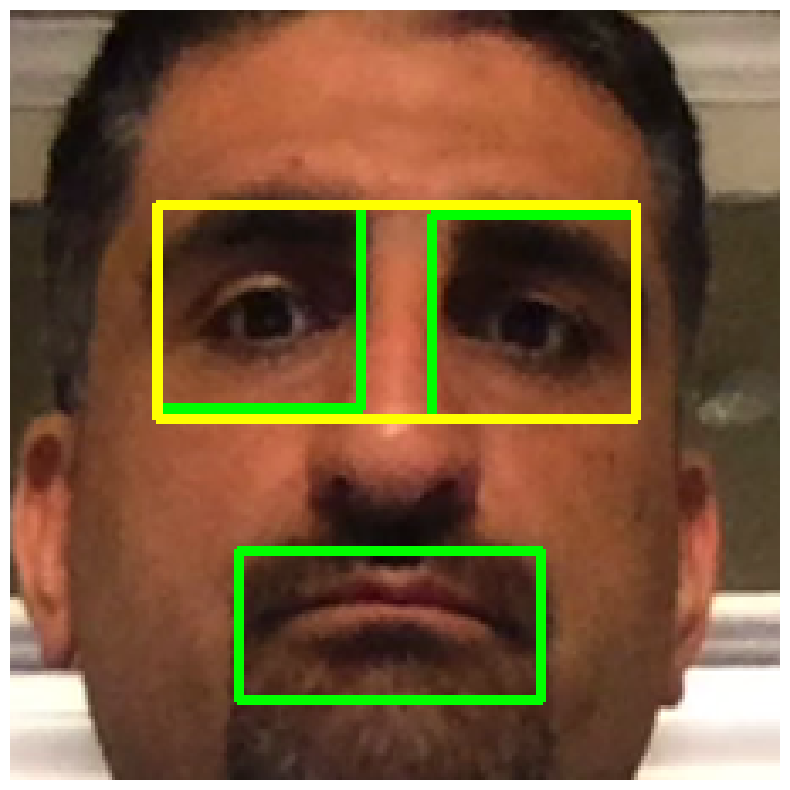

In [31]:
image_path = 'dataset\Drowsy\A0350.png'
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

detector = MTCNN()
detections = detector.detect_faces(img)

img_with_dets = img.copy()
min_conf = 0.9

det = detections[0]
if det['confidence'] >= min_conf:
    x, y, width, height = det['box']
    keypoints = det['keypoints']
    
    # Ambil koordinat mata kiri dan kanan
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']

    # Gambar kotak pembatas mata kiri
    cv2.rectangle(img_with_dets, (left_eye[0] - 30, left_eye[1] - 30), (left_eye[0] + 30, left_eye[1] + 30), (0, 255, 0), 2)

    # Gambar kotak pembatas mata kanan
    cv2.rectangle(img_with_dets, (right_eye[0] - 30, right_eye[1] - 30), (right_eye[0] + 30, right_eye[1] + 30), (0, 255, 0), 2)

    
    cv2.rectangle(img_with_dets, (left_eye[0] - 30, left_eye[1] -30), (right_eye[0] + 30, right_eye[1] + 30), (255, 255, 0), 2)

    
    # Ambil koordinat mulut
    mouth_left = keypoints['mouth_left']
    mouth_right = keypoints['mouth_right']

    # Gambar kotak pembatas mulut
    cv2.rectangle(img_with_dets, (mouth_left[0] - 10, mouth_left[1] - 20), (mouth_right[0] + 10, mouth_right[1] + 20), (0, 255, 0), 2)

plt.figure(figsize = (10,10))
plt.imshow(img_with_dets)
plt.axis('off')

Filtering detections with confidence greater than the confidence threshold and plotting detections

In [24]:
"""
Label
- label 1 : mulut
- label 2 : mata kanan objek
- label 3 : mata kiri objek
- label 4 : kedua mata
"""

'\nLabel\n- label 1 : mulut\n- label 2 : mata kanan objek\n- label 3 : mata kiri objek\n- label 4 : kedua mata\n'

In [28]:
def toYolo(x, y, w, h, image_width, image_height) :
    # Calculate YOLO format values
    cx = (x * 2 + w) / 2
    cy = (y * 2 + h) / 2
    bw = w
    bh = h

    normalized_cx = cx / image_width
    normalized_cy = cy / image_height
    normalized_bw = bw / image_width
    normalized_bh = bh / image_height

    return normalized_cx, normalized_cy, normalized_bw, normalized_bh

def copy(src, dst):
    if os.path.isdir(dst):
        dst = os.path.join(dst, os.path.basename(src))
    shutil.copyfile(src, dst)

In [32]:
error = 0
detector = MTCNN()

for path, subdirs, files in os.walk('dataset/'):
    for name in tqdm(files) :
        try :
            path_parts = path.split('/')
            label = path_parts[-1]

            # Load the input image
            img_path = os.path.join(path, name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            detections = detector.detect_faces(img)
            image_height, image_width, _ = img.shape

            img_with_dets = img.copy()
            min_conf = 0.9

            det = detections[0]
            if det['confidence'] >= min_conf:
                x, y, width, height = det['box']
                keypoints = det['keypoints']
                
                left_eye = keypoints['left_eye']
                right_eye = keypoints['right_eye']
                mouth_left = keypoints['mouth_left']
                mouth_right = keypoints['mouth_right']

                # Draw bounding boxes around the detected faces and display the image
                x_eyes, y_eyes, w_eyes, h_eyes = left_eye[0] - 30, left_eye[1] -30, right_eye[0] + 30, right_eye[1] + 30
                x_mouth, y_mouth, w_mouth, h_mouth = mouth_left[0] - 20, mouth_left[1] - 20, right_eye[0] + 20, right_eye[1] + 20
                x_r_eye, y_r_eye, w_r_eye, h_r_eye = right_eye[0] - 30, right_eye[1] - 30, right_eye[0] + 30, right_eye[1] + 30
                x_l_eye, y_l_eye, w_l_eye, h_l_eye = left_eye[0] - 30, left_eye[1] - 30, left_eye[0] + 30, left_eye[1] + 30
                
                normalized_cx_eyes, normalized_cy_eyes, normalized_bw_eyes, normalized_bh_eyes = toYolo(x_eyes, y_eyes, w_eyes, h_eyes, image_width, image_height)
                normalized_cx_mouth, normalized_cy_mouth, normalized_bw_mouth, normalized_bh_mouth = toYolo(x_mouth, y_mouth, w_mouth, h_mouth, image_width, image_height)
                normalized_cx_r_eye, normalized_cy_r_eye, normalized_bw_r_eye, normalized_bh_r_eye = toYolo(x_r_eye, y_r_eye, w_r_eye, h_r_eye, image_width, image_height)
                normalized_cx_l_eye, normalized_cy_l_eye, normalized_bw_l_eye, normalized_bh_l_eye = toYolo(x_l_eye, y_l_eye, w_l_eye, h_l_eye, image_width, image_height)

                # Convert to YOLO format line
                yolo_line = f"""1 {normalized_cx_mouth:.6f} {normalized_cy_mouth:.6f} {normalized_bw_mouth:.6f} {normalized_bh_mouth:.6f}
2 {normalized_cx_r_eye:.6f} {normalized_cy_r_eye:.6f} {normalized_bw_r_eye:.6f} {normalized_bh_r_eye:.6f}
3 {normalized_cx_l_eye:.6f} {normalized_cy_l_eye:.6f} {normalized_bw_l_eye:.6f} {normalized_bh_l_eye:.6f}
4 {normalized_cx_eyes:.6f} {normalized_cy_eyes:.6f} {normalized_bw_eyes:.6f} {normalized_bh_eyes:.6f}"""

                labels_folder = f"dataset sinta/labels/{label}"
                images_folder = f"dataset sinta/images/{label}"

                os.makedirs(labels_folder, exist_ok=True)
                os.makedirs(images_folder, exist_ok=True)

                copy(os.path.join(path, name), images_folder)
                with open(os.path.join(labels_folder, f'{name[:-4]}.txt'), 'w') as file:
                    file.write(yolo_line)

        except Exception as e :
            error += 1
            print(e)

print(error)

0it [00:00, ?it/s]
  0%|          | 0/22348 [00:00<?, ?it/s]

1/1 [==============================] - 0s 175ms/step


  0%|          | 1/22348 [00:01<10:45:51,  1.73s/it]

1/1 [==============================] - 0s 30ms/step


  0%|          | 2/22348 [00:02<7:30:19,  1.21s/it] 

1/1 [==============================] - 0s 15ms/step


  0%|          | 3/22348 [00:03<6:21:55,  1.03s/it]

1/1 [==============================] - 0s 38ms/step


  0%|          | 4/22348 [00:04<5:44:38,  1.08it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 5/22348 [00:04<5:27:39,  1.14it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 6/22348 [00:05<5:37:02,  1.10it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 7/22348 [00:06<5:27:25,  1.14it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 8/22348 [00:07<5:10:29,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 9/22348 [00:08<5:04:23,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 10/22348 [00:09<5:02:18,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 11/22348 [00:09<5:03:16,  1.23it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 12/22348 [00:10<5:12:40,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 13/22348 [00:11<5:15:09,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 14/22348 [00:12<5:50:04,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 15/22348 [00:13<5:37:34,  1.10it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 16/22348 [00:14<5:24:31,  1.15it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 17/22348 [00:15<5:22:44,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 18/22348 [00:16<5:21:29,  1.16it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 19/22348 [00:16<5:13:33,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 20/22348 [00:17<5:20:28,  1.16it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 21/22348 [00:18<5:28:47,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 22/22348 [00:19<5:21:16,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 23/22348 [00:20<5:13:25,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 24/22348 [00:21<5:14:11,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 25/22348 [00:22<5:09:44,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 26/22348 [00:22<5:06:11,  1.22it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 27/22348 [00:23<5:05:24,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 28/22348 [00:24<5:03:29,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 29/22348 [00:25<5:04:06,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 30/22348 [00:26<5:09:47,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 31/22348 [00:27<5:31:08,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 32/22348 [00:28<5:29:57,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 33/22348 [00:28<5:18:15,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 34/22348 [00:29<5:12:12,  1.19it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 35/22348 [00:30<5:08:03,  1.21it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 36/22348 [00:31<5:00:26,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 37/22348 [00:32<5:04:16,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 38/22348 [00:32<5:01:00,  1.24it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 39/22348 [00:33<5:07:06,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 40/22348 [00:34<5:05:30,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 41/22348 [00:35<4:57:04,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 42/22348 [00:35<4:53:13,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 43/22348 [00:36<4:53:09,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 44/22348 [00:37<4:50:49,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 45/22348 [00:38<4:47:58,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 46/22348 [00:39<4:47:46,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 47/22348 [00:39<4:44:18,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 48/22348 [00:40<4:46:20,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 49/22348 [00:41<4:47:04,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 50/22348 [00:42<4:45:34,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 51/22348 [00:42<4:48:37,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 52/22348 [00:43<4:45:45,  1.30it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 53/22348 [00:44<4:52:13,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 54/22348 [00:45<4:51:38,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 55/22348 [00:46<4:48:33,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 56/22348 [00:46<4:55:33,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 57/22348 [00:47<4:50:33,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 58/22348 [00:48<4:50:50,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 59/22348 [00:49<4:56:35,  1.25it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 60/22348 [00:50<4:57:46,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 61/22348 [00:50<4:56:14,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 62/22348 [00:51<4:53:23,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 63/22348 [00:52<4:52:02,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 64/22348 [00:53<4:56:06,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 65/22348 [00:54<4:57:48,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 66/22348 [00:54<4:56:50,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 67/22348 [00:55<5:00:56,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 68/22348 [00:56<4:58:40,  1.24it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 69/22348 [00:57<4:57:57,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 70/22348 [00:58<5:04:02,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 71/22348 [00:58<5:03:48,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 72/22348 [00:59<5:02:14,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 73/22348 [01:00<5:06:46,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 74/22348 [01:01<5:03:19,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 75/22348 [01:02<4:59:49,  1.24it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 76/22348 [01:02<4:57:01,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 77/22348 [01:03<4:53:19,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 78/22348 [01:04<4:51:39,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 79/22348 [01:05<4:51:05,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 80/22348 [01:06<4:50:50,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 81/22348 [01:06<4:56:16,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 82/22348 [01:07<4:51:01,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 83/22348 [01:08<4:51:19,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 84/22348 [01:09<4:52:25,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 85/22348 [01:10<4:54:21,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 86/22348 [01:10<4:54:39,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 87/22348 [01:11<4:58:25,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 88/22348 [01:12<5:03:58,  1.22it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 89/22348 [01:13<4:58:52,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 90/22348 [01:14<4:59:06,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 91/22348 [01:14<4:58:07,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 92/22348 [01:15<4:55:35,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 93/22348 [01:16<4:53:21,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 94/22348 [01:17<4:53:27,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 95/22348 [01:18<4:49:48,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 96/22348 [01:18<4:56:23,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 97/22348 [01:19<4:57:19,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 98/22348 [01:20<4:54:33,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 99/22348 [01:21<5:03:16,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 100/22348 [01:22<4:59:51,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 101/22348 [01:22<4:59:32,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 102/22348 [01:23<4:53:02,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 103/22348 [01:24<5:12:58,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 104/22348 [01:25<5:30:55,  1.12it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 105/22348 [01:26<5:34:33,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 106/22348 [01:27<5:36:59,  1.10it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 107/22348 [01:28<5:45:33,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 108/22348 [01:29<5:40:19,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 109/22348 [01:30<5:42:37,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 110/22348 [01:31<5:40:18,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 111/22348 [01:32<5:27:29,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 112/22348 [01:32<5:16:47,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 113/22348 [01:33<5:10:07,  1.19it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 114/22348 [01:34<5:02:17,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 115/22348 [01:35<4:57:12,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 116/22348 [01:35<4:53:05,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 117/22348 [01:36<4:52:01,  1.27it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 118/22348 [01:37<4:54:36,  1.26it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 119/22348 [01:38<4:58:53,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 120/22348 [01:39<4:56:24,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 121/22348 [01:39<4:56:14,  1.25it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 122/22348 [01:40<4:58:36,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 123/22348 [01:41<4:56:58,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 124/22348 [01:42<5:00:03,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 125/22348 [01:43<4:55:11,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 126/22348 [01:44<5:06:14,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 127/22348 [01:44<5:05:06,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 128/22348 [01:45<5:04:01,  1.22it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 129/22348 [01:46<5:04:55,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 130/22348 [01:47<5:41:51,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 131/22348 [01:48<5:33:34,  1.11it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 132/22348 [01:49<5:36:58,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 133/22348 [01:50<5:37:00,  1.10it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 134/22348 [01:51<5:33:27,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 135/22348 [01:51<5:20:19,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 136/22348 [01:52<5:18:53,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 137/22348 [01:53<5:19:23,  1.16it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 138/22348 [01:54<5:13:03,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 139/22348 [01:55<5:10:35,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 140/22348 [01:56<5:12:47,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 141/22348 [01:57<5:24:35,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 142/22348 [01:57<5:18:33,  1.16it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 143/22348 [01:58<5:15:53,  1.17it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 144/22348 [01:59<5:15:17,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 145/22348 [02:00<5:08:57,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 146/22348 [02:01<5:08:57,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 147/22348 [02:02<5:04:23,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 148/22348 [02:02<5:13:14,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 149/22348 [02:03<5:07:40,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 150/22348 [02:04<5:03:33,  1.22it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 151/22348 [02:05<5:04:38,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 152/22348 [02:06<4:58:59,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 153/22348 [02:07<5:02:45,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 154/22348 [02:07<5:05:38,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 155/22348 [02:08<5:08:15,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 156/22348 [02:09<5:10:14,  1.19it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 157/22348 [02:10<5:06:32,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 158/22348 [02:11<5:07:59,  1.20it/s]

1/1 [==============================] - 0s 9ms/step


  1%|          | 159/22348 [02:12<5:07:11,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 160/22348 [02:12<5:04:37,  1.21it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 161/22348 [02:13<5:06:16,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 162/22348 [02:14<5:11:36,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 163/22348 [02:15<5:04:30,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 164/22348 [02:16<5:06:57,  1.20it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 165/22348 [02:17<5:08:51,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 166/22348 [02:17<5:09:13,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 167/22348 [02:18<5:12:33,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 168/22348 [02:19<5:12:00,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 169/22348 [02:20<5:09:56,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 170/22348 [02:21<5:15:09,  1.17it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 171/22348 [02:22<5:09:28,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 172/22348 [02:22<5:05:57,  1.21it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 173/22348 [02:23<5:03:40,  1.22it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 174/22348 [02:24<5:03:57,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 175/22348 [02:25<5:02:30,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 176/22348 [02:26<4:58:13,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 177/22348 [02:26<5:06:56,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 178/22348 [02:27<5:03:34,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 179/22348 [02:28<5:07:24,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 180/22348 [02:29<5:06:39,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 181/22348 [02:30<5:05:09,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 182/22348 [02:31<5:07:30,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 183/22348 [02:31<5:05:32,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 184/22348 [02:32<5:06:11,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 185/22348 [02:33<5:04:10,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 186/22348 [02:34<5:02:26,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 187/22348 [02:35<5:07:14,  1.20it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 188/22348 [02:36<5:06:36,  1.20it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 189/22348 [02:37<5:18:16,  1.16it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 190/22348 [02:37<5:19:24,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 191/22348 [02:38<5:21:51,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 192/22348 [02:39<5:12:32,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 193/22348 [02:40<5:11:02,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 194/22348 [02:41<5:10:13,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 195/22348 [02:42<5:10:31,  1.19it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 196/22348 [02:42<5:03:44,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 197/22348 [02:43<5:02:11,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 198/22348 [02:44<5:06:52,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 199/22348 [02:45<5:09:26,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 200/22348 [02:46<5:08:00,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 201/22348 [02:47<5:06:04,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 202/22348 [02:47<5:05:26,  1.21it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 203/22348 [02:48<5:05:16,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 204/22348 [02:49<5:04:48,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 205/22348 [02:50<5:10:28,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 206/22348 [02:51<5:08:46,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 207/22348 [02:52<5:05:42,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 208/22348 [02:52<5:05:31,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 209/22348 [02:53<5:02:57,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 210/22348 [02:54<5:04:34,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 211/22348 [02:55<5:05:09,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 212/22348 [02:56<5:07:19,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 213/22348 [02:57<5:09:24,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 214/22348 [02:57<5:10:16,  1.19it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 215/22348 [02:58<5:10:08,  1.19it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 216/22348 [02:59<5:09:01,  1.19it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 217/22348 [03:00<5:08:49,  1.19it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 218/22348 [03:01<5:06:10,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 219/22348 [03:02<5:13:25,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 220/22348 [03:02<5:06:00,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 221/22348 [03:03<5:05:36,  1.21it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 222/22348 [03:04<5:01:07,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 223/22348 [03:05<4:57:03,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 224/22348 [03:06<4:58:32,  1.24it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 225/22348 [03:06<4:57:26,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 226/22348 [03:07<5:13:14,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 227/22348 [03:08<5:10:29,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 228/22348 [03:09<5:08:32,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 229/22348 [03:10<5:09:08,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 230/22348 [03:11<5:04:55,  1.21it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 231/22348 [03:11<5:05:06,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 232/22348 [03:12<5:03:34,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 233/22348 [03:13<5:07:03,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 234/22348 [03:14<5:00:49,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 235/22348 [03:15<5:03:14,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 236/22348 [03:16<5:01:28,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 237/22348 [03:16<5:00:50,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 238/22348 [03:17<5:03:32,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 239/22348 [03:18<5:01:01,  1.22it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 240/22348 [03:19<5:01:23,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 241/22348 [03:20<5:02:36,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 242/22348 [03:20<5:04:59,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 243/22348 [03:21<5:07:06,  1.20it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 244/22348 [03:22<5:12:38,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 245/22348 [03:23<5:17:48,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 246/22348 [03:24<5:51:57,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 247/22348 [03:25<5:38:36,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 248/22348 [03:26<5:41:53,  1.08it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 249/22348 [03:27<5:19:20,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 250/22348 [03:28<5:08:00,  1.20it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 251/22348 [03:28<4:49:31,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 252/22348 [03:29<4:37:44,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 253/22348 [03:30<4:30:26,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 254/22348 [03:30<4:22:34,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 255/22348 [03:31<4:15:22,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 256/22348 [03:32<4:11:03,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 257/22348 [03:32<4:09:12,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 258/22348 [03:33<4:10:00,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 259/22348 [03:34<4:10:50,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 260/22348 [03:34<4:22:00,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 261/22348 [03:35<4:30:04,  1.36it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 262/22348 [03:36<4:34:51,  1.34it/s]

1/1 [==============================] - 0s 11ms/step


  1%|          | 263/22348 [03:37<4:37:04,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 264/22348 [03:38<4:47:44,  1.28it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 265/22348 [03:38<4:50:32,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 266/22348 [03:39<4:39:35,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 267/22348 [03:40<4:29:20,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 268/22348 [03:40<4:28:00,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 269/22348 [03:41<4:21:14,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 270/22348 [03:42<4:23:23,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 271/22348 [03:43<4:34:35,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 272/22348 [03:43<4:35:13,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 273/22348 [03:44<4:41:30,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 274/22348 [03:45<4:40:52,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 275/22348 [03:46<4:52:45,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 276/22348 [03:47<4:45:29,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 277/22348 [03:47<4:53:29,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 278/22348 [03:48<4:46:18,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 279/22348 [03:49<4:54:09,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 280/22348 [03:50<4:52:34,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 281/22348 [03:51<4:44:35,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 282/22348 [03:51<4:50:14,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 283/22348 [03:52<4:59:05,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 284/22348 [03:53<4:56:05,  1.24it/s]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 285/22348 [03:54<5:30:37,  1.11it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 286/22348 [03:55<6:05:28,  1.01it/s]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 287/22348 [03:56<6:18:31,  1.03s/it]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 288/22348 [03:58<6:33:24,  1.07s/it]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 289/22348 [03:59<7:07:17,  1.16s/it]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 290/22348 [04:00<7:06:34,  1.16s/it]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 291/22348 [04:01<7:07:45,  1.16s/it]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 292/22348 [04:03<7:16:50,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 293/22348 [04:04<7:19:17,  1.20s/it]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 294/22348 [04:05<7:22:10,  1.20s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 295/22348 [04:06<7:26:25,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 296/22348 [04:07<7:20:44,  1.20s/it]

1/1 [==============================] - 0s 50ms/step


  1%|▏         | 297/22348 [04:09<7:26:28,  1.21s/it]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 298/22348 [04:10<7:21:25,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


  1%|▏         | 299/22348 [04:11<7:28:05,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 300/22348 [04:12<7:25:06,  1.21s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▏         | 301/22348 [04:13<7:26:30,  1.22s/it]

1/1 [==============================] - 0s 56ms/step


  1%|▏         | 302/22348 [04:15<7:29:54,  1.22s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 303/22348 [04:16<7:24:22,  1.21s/it]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 304/22348 [04:17<7:27:50,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 305/22348 [04:18<7:29:23,  1.22s/it]

1/1 [==============================] - 0s 49ms/step


  1%|▏         | 306/22348 [04:20<7:24:21,  1.21s/it]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 307/22348 [04:21<7:30:55,  1.23s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 308/22348 [04:22<7:24:09,  1.21s/it]

1/1 [==============================] - 0s 57ms/step


  1%|▏         | 309/22348 [04:23<7:29:30,  1.22s/it]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 310/22348 [04:25<7:53:14,  1.29s/it]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 311/22348 [04:26<7:05:54,  1.16s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 312/22348 [04:26<6:24:16,  1.05s/it]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 313/22348 [04:27<5:51:39,  1.04it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 314/22348 [04:28<5:38:08,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 315/22348 [04:29<5:21:06,  1.14it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 316/22348 [04:29<5:09:48,  1.19it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 317/22348 [04:30<5:14:11,  1.17it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 318/22348 [04:31<5:00:12,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 319/22348 [04:32<4:57:29,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 320/22348 [04:33<5:06:55,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 321/22348 [04:34<5:06:00,  1.20it/s]

1/1 [==============================] - 0s 50ms/step


  1%|▏         | 322/22348 [04:35<5:21:41,  1.14it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 323/22348 [04:36<6:02:50,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 324/22348 [04:37<6:34:18,  1.07s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 325/22348 [04:38<6:53:37,  1.13s/it]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 326/22348 [04:40<7:02:56,  1.15s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 327/22348 [04:41<7:13:13,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 328/22348 [04:42<7:09:11,  1.17s/it]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 329/22348 [04:43<7:10:35,  1.17s/it]

1/1 [==============================] - 0s 61ms/step


  1%|▏         | 330/22348 [04:44<7:18:22,  1.19s/it]

1/1 [==============================] - 0s 52ms/step


  1%|▏         | 331/22348 [04:46<7:26:48,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 332/22348 [04:47<7:26:32,  1.22s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▏         | 333/22348 [04:48<7:23:04,  1.21s/it]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 334/22348 [04:49<7:16:39,  1.19s/it]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 335/22348 [04:50<7:14:09,  1.18s/it]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 336/22348 [04:51<7:07:48,  1.17s/it]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 337/22348 [04:53<7:00:57,  1.15s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 338/22348 [04:54<7:13:16,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 339/22348 [04:55<7:22:10,  1.21s/it]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 340/22348 [04:57<7:52:00,  1.29s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 341/22348 [04:58<8:13:59,  1.35s/it]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 342/22348 [05:00<8:31:53,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 343/22348 [05:01<7:48:53,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 344/22348 [05:01<7:03:14,  1.15s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 345/22348 [05:02<6:17:39,  1.03s/it]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 346/22348 [05:03<5:51:47,  1.04it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 347/22348 [05:04<5:42:05,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 348/22348 [05:05<5:39:01,  1.08it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 349/22348 [05:06<5:26:08,  1.12it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 350/22348 [05:06<5:22:01,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 351/22348 [05:07<5:09:34,  1.18it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 352/22348 [05:08<5:02:43,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 353/22348 [05:09<4:54:27,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 354/22348 [05:10<5:03:38,  1.21it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 355/22348 [05:11<5:41:15,  1.07it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 356/22348 [05:12<6:01:06,  1.02it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 357/22348 [05:13<6:15:16,  1.02s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 358/22348 [05:14<6:29:31,  1.06s/it]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 359/22348 [05:15<6:34:37,  1.08s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 360/22348 [05:16<6:46:49,  1.11s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 361/22348 [05:18<6:47:24,  1.11s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 362/22348 [05:19<6:46:10,  1.11s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 363/22348 [05:20<7:43:25,  1.26s/it]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 364/22348 [05:21<7:26:23,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 365/22348 [05:23<7:21:57,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 366/22348 [05:24<7:14:54,  1.19s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 367/22348 [05:25<7:07:55,  1.17s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 368/22348 [05:26<7:09:32,  1.17s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 369/22348 [05:27<7:00:28,  1.15s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 370/22348 [05:28<7:04:20,  1.16s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 371/22348 [05:29<6:56:07,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 372/22348 [05:31<7:04:56,  1.16s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 373/22348 [05:32<7:09:03,  1.17s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 374/22348 [05:33<7:12:16,  1.18s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 375/22348 [05:34<7:08:40,  1.17s/it]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 376/22348 [05:35<7:06:04,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 377/22348 [05:36<6:51:12,  1.12s/it]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 378/22348 [05:37<6:11:14,  1.01s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 379/22348 [05:38<6:01:29,  1.01it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 380/22348 [05:39<6:22:00,  1.04s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 381/22348 [05:40<6:32:04,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 382/22348 [05:41<6:43:32,  1.10s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 383/22348 [05:43<6:47:55,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 384/22348 [05:44<6:59:21,  1.15s/it]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 385/22348 [05:45<6:57:30,  1.14s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 386/22348 [05:46<6:54:54,  1.13s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 387/22348 [05:47<6:58:40,  1.14s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 388/22348 [05:48<6:55:14,  1.13s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 389/22348 [05:50<6:56:40,  1.14s/it]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 390/22348 [05:51<7:01:35,  1.15s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 391/22348 [05:52<7:01:28,  1.15s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 392/22348 [05:53<6:50:18,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 393/22348 [05:54<6:57:22,  1.14s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 394/22348 [05:55<6:52:39,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 395/22348 [05:56<7:07:00,  1.17s/it]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 396/22348 [05:58<7:08:05,  1.17s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 397/22348 [05:59<7:29:43,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 398/22348 [06:00<7:33:50,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 399/22348 [06:02<7:33:14,  1.24s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 400/22348 [06:03<7:27:03,  1.22s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 401/22348 [06:04<7:29:33,  1.23s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 402/22348 [06:05<7:15:13,  1.19s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 403/22348 [06:06<7:16:37,  1.19s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 404/22348 [06:08<7:28:37,  1.23s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 405/22348 [06:09<7:23:54,  1.21s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 406/22348 [06:10<7:31:18,  1.23s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 407/22348 [06:11<7:31:51,  1.24s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 408/22348 [06:12<7:32:04,  1.24s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 409/22348 [06:14<7:25:09,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 410/22348 [06:15<7:26:37,  1.22s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 411/22348 [06:16<7:13:34,  1.19s/it]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 412/22348 [06:17<7:25:34,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 413/22348 [06:18<7:21:47,  1.21s/it]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 414/22348 [06:20<7:12:52,  1.18s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 415/22348 [06:21<7:10:25,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 416/22348 [06:22<7:20:48,  1.21s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 417/22348 [06:23<7:29:44,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 418/22348 [06:24<7:23:39,  1.21s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 419/22348 [06:26<7:31:30,  1.24s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 420/22348 [06:27<7:32:48,  1.24s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 421/22348 [06:28<7:30:30,  1.23s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 422/22348 [06:29<7:30:13,  1.23s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 423/22348 [06:31<7:31:44,  1.24s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 424/22348 [06:32<7:34:22,  1.24s/it]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 425/22348 [06:33<7:31:06,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 426/22348 [06:34<7:13:46,  1.19s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 427/22348 [06:35<6:58:59,  1.15s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 428/22348 [06:37<7:03:54,  1.16s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 429/22348 [06:38<7:06:32,  1.17s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 430/22348 [06:39<7:01:46,  1.15s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 431/22348 [06:40<7:02:00,  1.16s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 432/22348 [06:41<6:57:45,  1.14s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 433/22348 [06:42<7:09:09,  1.17s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 434/22348 [06:44<7:21:39,  1.21s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 435/22348 [06:45<7:14:38,  1.19s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 436/22348 [06:46<7:24:30,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 437/22348 [06:47<7:32:35,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 438/22348 [06:49<7:39:59,  1.26s/it]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 439/22348 [06:50<7:54:44,  1.30s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 440/22348 [06:51<7:58:27,  1.31s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 441/22348 [06:52<7:16:28,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 442/22348 [06:53<6:31:13,  1.07s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 443/22348 [06:54<5:56:21,  1.02it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 444/22348 [06:55<5:42:18,  1.07it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 445/22348 [06:56<5:31:05,  1.10it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 446/22348 [06:56<5:20:49,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 447/22348 [06:57<5:15:47,  1.16it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 448/22348 [06:58<5:18:24,  1.15it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 449/22348 [06:59<5:19:41,  1.14it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 450/22348 [07:00<5:22:07,  1.13it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 451/22348 [07:01<5:51:24,  1.04it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 452/22348 [07:02<6:22:19,  1.05s/it]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 453/22348 [07:04<6:49:02,  1.12s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 454/22348 [07:05<7:12:24,  1.19s/it]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 455/22348 [07:06<7:39:15,  1.26s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 456/22348 [07:08<7:35:25,  1.25s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 457/22348 [07:08<6:43:43,  1.11s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 458/22348 [07:09<6:10:37,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 459/22348 [07:10<5:52:45,  1.03it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 460/22348 [07:11<5:43:58,  1.06it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 461/22348 [07:12<5:29:32,  1.11it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 462/22348 [07:13<5:24:44,  1.12it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 463/22348 [07:14<5:47:26,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 464/22348 [07:15<6:15:09,  1.03s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 465/22348 [07:16<6:46:42,  1.12s/it]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 466/22348 [07:17<6:51:56,  1.13s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 467/22348 [07:19<7:04:59,  1.17s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 468/22348 [07:20<7:11:53,  1.18s/it]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 469/22348 [07:21<7:38:15,  1.26s/it]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 470/22348 [07:23<7:46:03,  1.28s/it]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 471/22348 [07:24<7:48:07,  1.28s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 472/22348 [07:25<7:26:12,  1.22s/it]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 473/22348 [07:26<6:35:02,  1.08s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 474/22348 [07:26<6:04:58,  1.00s/it]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 475/22348 [07:27<5:48:23,  1.05it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 476/22348 [07:28<5:40:15,  1.07it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 477/22348 [07:29<5:31:54,  1.10it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 478/22348 [07:30<5:30:00,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 479/22348 [07:31<6:04:05,  1.00it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 480/22348 [07:32<5:53:06,  1.03it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 481/22348 [07:33<6:22:56,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 482/22348 [07:35<6:39:03,  1.10s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 483/22348 [07:36<7:02:05,  1.16s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 484/22348 [07:37<7:26:51,  1.23s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 485/22348 [07:39<7:42:03,  1.27s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 486/22348 [07:40<7:55:54,  1.31s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 487/22348 [07:41<7:53:08,  1.30s/it]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 488/22348 [07:42<7:39:14,  1.26s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 489/22348 [07:44<7:27:45,  1.23s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 490/22348 [07:45<7:20:31,  1.21s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 491/22348 [07:46<7:28:01,  1.23s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 492/22348 [07:47<7:34:56,  1.25s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 493/22348 [07:49<7:41:54,  1.27s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 494/22348 [07:50<7:53:13,  1.30s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 495/22348 [07:51<8:03:25,  1.33s/it]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 496/22348 [07:53<8:07:35,  1.34s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 497/22348 [07:54<7:55:07,  1.30s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 498/22348 [07:55<7:44:16,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 499/22348 [07:56<6:57:48,  1.15s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 500/22348 [07:57<6:23:09,  1.05s/it]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 501/22348 [07:58<6:18:57,  1.04s/it]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 502/22348 [07:59<6:00:29,  1.01it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 503/22348 [08:00<5:42:38,  1.06it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 504/22348 [08:00<5:29:02,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 505/22348 [08:01<5:21:58,  1.13it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 506/22348 [08:02<5:25:11,  1.12it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 507/22348 [08:04<6:16:06,  1.03s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 508/22348 [08:05<6:44:04,  1.11s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 509/22348 [08:06<6:52:32,  1.13s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 510/22348 [08:07<7:03:49,  1.16s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 511/22348 [08:08<7:12:34,  1.19s/it]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 512/22348 [08:10<7:12:15,  1.19s/it]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 513/22348 [08:11<7:21:30,  1.21s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 514/22348 [08:12<7:17:55,  1.20s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 515/22348 [08:13<7:19:42,  1.21s/it]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 516/22348 [08:15<7:25:48,  1.23s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 517/22348 [08:16<7:38:40,  1.26s/it]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 518/22348 [08:17<7:45:35,  1.28s/it]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 519/22348 [08:19<7:46:46,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 520/22348 [08:20<8:00:14,  1.32s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 521/22348 [08:21<7:57:16,  1.31s/it]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 522/22348 [08:22<7:49:50,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 523/22348 [08:24<7:43:50,  1.28s/it]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 524/22348 [08:25<7:32:47,  1.24s/it]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 525/22348 [08:26<7:25:33,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 526/22348 [08:27<7:21:02,  1.21s/it]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 527/22348 [08:29<7:24:09,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 528/22348 [08:30<7:22:56,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 529/22348 [08:31<7:31:09,  1.24s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 530/22348 [08:32<7:30:12,  1.24s/it]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 531/22348 [08:33<7:28:57,  1.23s/it]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 532/22348 [08:35<7:33:07,  1.25s/it]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 533/22348 [08:36<7:41:23,  1.27s/it]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 534/22348 [08:37<7:36:51,  1.26s/it]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 535/22348 [08:39<7:42:07,  1.27s/it]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 536/22348 [08:40<7:43:57,  1.28s/it]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 537/22348 [08:41<7:48:51,  1.29s/it]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 538/22348 [08:42<7:26:56,  1.23s/it]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 539/22348 [08:43<6:43:38,  1.11s/it]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 540/22348 [08:44<6:15:35,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 541/22348 [08:45<5:59:41,  1.01it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 542/22348 [08:46<5:55:30,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 543/22348 [08:47<5:37:29,  1.08it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 544/22348 [08:47<5:27:00,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 545/22348 [08:48<5:17:59,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 546/22348 [08:49<5:15:10,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 547/22348 [08:50<5:18:12,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 548/22348 [08:51<5:12:56,  1.16it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 549/22348 [08:52<5:12:18,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 550/22348 [08:53<5:06:13,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 551/22348 [08:53<5:08:35,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 552/22348 [08:54<5:06:09,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 553/22348 [08:55<5:06:30,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 554/22348 [08:56<5:10:02,  1.17it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 555/22348 [08:57<5:10:05,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 556/22348 [08:58<5:04:56,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 557/22348 [08:58<5:06:39,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 558/22348 [08:59<5:03:57,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 559/22348 [09:00<5:01:06,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 560/22348 [09:01<4:58:50,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 561/22348 [09:02<5:01:41,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 562/22348 [09:03<4:57:23,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 563/22348 [09:03<4:55:24,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 564/22348 [09:04<4:54:07,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 565/22348 [09:05<5:01:20,  1.20it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 566/22348 [09:06<5:00:57,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 567/22348 [09:07<4:59:25,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 568/22348 [09:07<5:00:34,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 569/22348 [09:08<5:04:56,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 570/22348 [09:09<4:56:33,  1.22it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 571/22348 [09:10<4:58:59,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 572/22348 [09:11<5:18:05,  1.14it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 573/22348 [09:12<5:30:56,  1.10it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 574/22348 [09:13<5:25:35,  1.11it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 575/22348 [09:14<5:23:59,  1.12it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 576/22348 [09:15<5:17:26,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 577/22348 [09:15<5:12:54,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 578/22348 [09:16<5:05:27,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 579/22348 [09:17<4:55:48,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 580/22348 [09:18<4:58:03,  1.22it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 581/22348 [09:18<4:48:04,  1.26it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 582/22348 [09:19<4:49:12,  1.25it/s]

1/1 [==============================] - 0s 10ms/step


  3%|▎         | 583/22348 [09:20<4:47:13,  1.26it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 584/22348 [09:21<4:39:43,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 585/22348 [09:22<4:53:35,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 586/22348 [09:23<4:58:00,  1.22it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 587/22348 [09:23<5:00:51,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 588/22348 [09:24<5:00:52,  1.21it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 589/22348 [09:25<5:01:00,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 590/22348 [09:26<4:58:53,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 591/22348 [09:27<5:17:46,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 592/22348 [09:28<5:17:24,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 593/22348 [09:29<5:17:13,  1.14it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 594/22348 [09:30<5:36:15,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 595/22348 [09:30<5:19:25,  1.14it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 596/22348 [09:31<5:31:52,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 597/22348 [09:32<5:14:03,  1.15it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 598/22348 [09:33<5:41:10,  1.06it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 599/22348 [09:34<5:38:27,  1.07it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 600/22348 [09:35<5:39:56,  1.07it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 601/22348 [09:36<5:43:07,  1.06it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 602/22348 [09:37<5:48:52,  1.04it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 603/22348 [09:38<6:05:37,  1.01s/it]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 604/22348 [09:39<6:30:48,  1.08s/it]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 605/22348 [09:41<6:50:37,  1.13s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 606/22348 [09:42<7:09:32,  1.19s/it]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 607/22348 [09:43<7:27:24,  1.23s/it]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 608/22348 [09:45<7:23:44,  1.22s/it]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 609/22348 [09:46<7:34:07,  1.25s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 610/22348 [09:47<7:38:54,  1.27s/it]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 611/22348 [09:49<7:44:06,  1.28s/it]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 612/22348 [09:50<7:49:52,  1.30s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 613/22348 [09:51<8:11:09,  1.36s/it]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 614/22348 [09:53<8:17:18,  1.37s/it]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 615/22348 [09:54<8:13:23,  1.36s/it]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 616/22348 [09:56<8:30:41,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 617/22348 [09:57<8:24:08,  1.39s/it]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 618/22348 [09:58<8:20:38,  1.38s/it]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 619/22348 [10:00<8:24:31,  1.39s/it]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 620/22348 [10:01<8:23:29,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 621/22348 [10:02<8:16:57,  1.37s/it]

1/1 [==============================] - 0s 79ms/step


  3%|▎         | 622/22348 [10:04<8:10:54,  1.36s/it]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 623/22348 [10:05<8:08:26,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 624/22348 [10:06<8:01:13,  1.33s/it]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 625/22348 [10:08<8:12:41,  1.36s/it]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 626/22348 [10:09<8:16:45,  1.37s/it]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 627/22348 [10:11<8:28:41,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 628/22348 [10:12<8:12:46,  1.36s/it]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 629/22348 [10:13<8:05:38,  1.34s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 630/22348 [10:15<8:09:45,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 631/22348 [10:16<8:14:49,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 632/22348 [10:17<8:11:08,  1.36s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 633/22348 [10:19<8:14:08,  1.37s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 634/22348 [10:20<8:24:50,  1.39s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 635/22348 [10:22<8:25:31,  1.40s/it]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 636/22348 [10:23<8:22:12,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 637/22348 [10:24<8:32:46,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 638/22348 [10:26<8:39:38,  1.44s/it]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 639/22348 [10:27<8:23:21,  1.39s/it]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 640/22348 [10:29<8:14:55,  1.37s/it]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 641/22348 [10:30<8:24:17,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 642/22348 [10:31<8:25:02,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 643/22348 [10:33<8:30:39,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 644/22348 [10:34<8:25:50,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 645/22348 [10:36<8:22:37,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 646/22348 [10:37<8:11:03,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 647/22348 [10:38<7:59:06,  1.32s/it]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 648/22348 [10:40<8:06:17,  1.34s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 649/22348 [10:41<8:20:10,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 650/22348 [10:42<8:31:15,  1.41s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 651/22348 [10:44<8:23:52,  1.39s/it]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 652/22348 [10:45<8:20:28,  1.38s/it]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 653/22348 [10:47<8:27:15,  1.40s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 654/22348 [10:48<8:22:40,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 655/22348 [10:49<8:09:34,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 656/22348 [10:50<7:40:47,  1.27s/it]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 657/22348 [10:52<7:43:20,  1.28s/it]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 658/22348 [10:53<8:07:18,  1.35s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 659/22348 [10:55<8:12:16,  1.36s/it]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 660/22348 [10:56<8:20:30,  1.38s/it]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 661/22348 [10:57<8:04:27,  1.34s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 662/22348 [10:59<8:11:23,  1.36s/it]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 663/22348 [11:00<8:05:58,  1.34s/it]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 664/22348 [11:01<8:07:39,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 665/22348 [11:03<8:14:48,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 666/22348 [11:04<8:06:41,  1.35s/it]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 667/22348 [11:05<7:52:50,  1.31s/it]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 668/22348 [11:06<7:43:25,  1.28s/it]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 669/22348 [11:08<7:50:19,  1.30s/it]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 670/22348 [11:09<8:01:15,  1.33s/it]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 671/22348 [11:11<7:58:59,  1.33s/it]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 672/22348 [11:12<7:45:15,  1.29s/it]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 673/22348 [11:13<7:47:52,  1.30s/it]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 674/22348 [11:14<7:47:08,  1.29s/it]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 675/22348 [11:16<7:39:50,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 676/22348 [11:17<7:48:02,  1.30s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 677/22348 [11:18<7:59:21,  1.33s/it]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 678/22348 [11:20<8:02:06,  1.33s/it]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 679/22348 [11:21<7:55:10,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 680/22348 [11:22<8:01:19,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 681/22348 [11:23<7:28:23,  1.24s/it]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 682/22348 [11:24<6:40:16,  1.11s/it]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 683/22348 [11:25<6:06:48,  1.02s/it]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 684/22348 [11:26<5:43:53,  1.05it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 685/22348 [11:27<5:32:14,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 686/22348 [11:27<5:18:13,  1.13it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 687/22348 [11:28<5:10:08,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 688/22348 [11:29<5:02:59,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 689/22348 [11:30<4:59:37,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 690/22348 [11:31<4:50:03,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 691/22348 [11:31<4:54:56,  1.22it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 692/22348 [11:32<4:57:56,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 693/22348 [11:33<4:59:16,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 694/22348 [11:34<5:02:42,  1.19it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 695/22348 [11:35<5:04:42,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 696/22348 [11:36<5:08:08,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 697/22348 [11:37<5:18:46,  1.13it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 698/22348 [11:38<5:31:24,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 699/22348 [11:38<5:21:54,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 700/22348 [11:39<5:16:09,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 701/22348 [11:40<5:07:40,  1.17it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 702/22348 [11:41<5:04:55,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 703/22348 [11:42<5:01:59,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 704/22348 [11:43<5:04:02,  1.19it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 705/22348 [11:43<5:11:54,  1.16it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 706/22348 [11:44<5:07:56,  1.17it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 707/22348 [11:45<5:05:48,  1.18it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 708/22348 [11:46<5:07:44,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 709/22348 [11:47<5:05:50,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 710/22348 [11:48<5:12:03,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 711/22348 [11:49<5:38:47,  1.06it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 712/22348 [11:50<5:14:13,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 713/22348 [11:50<4:59:15,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 714/22348 [11:51<4:56:01,  1.22it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 715/22348 [11:52<4:51:47,  1.24it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 716/22348 [11:53<4:44:03,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 717/22348 [11:53<4:41:23,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 718/22348 [11:54<4:47:06,  1.26it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 719/22348 [11:55<4:42:27,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 720/22348 [11:56<4:36:57,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 721/22348 [11:56<4:32:50,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 722/22348 [11:57<4:41:04,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 723/22348 [11:58<4:36:51,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 724/22348 [11:59<4:34:42,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 725/22348 [12:00<4:34:35,  1.31it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 726/22348 [12:00<4:40:22,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 727/22348 [12:01<4:35:46,  1.31it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 728/22348 [12:02<4:35:41,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 729/22348 [12:03<4:32:17,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 730/22348 [12:03<4:38:57,  1.29it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 731/22348 [12:04<4:36:14,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 732/22348 [12:05<4:34:17,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 733/22348 [12:06<4:31:24,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 734/22348 [12:06<4:36:22,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 735/22348 [12:07<4:33:08,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 736/22348 [12:08<4:35:17,  1.31it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 737/22348 [12:09<4:32:19,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 738/22348 [12:09<4:35:52,  1.31it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 739/22348 [12:10<4:39:12,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 740/22348 [12:11<4:32:18,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 741/22348 [12:12<4:33:24,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 742/22348 [12:13<4:38:39,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 743/22348 [12:13<4:37:00,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 744/22348 [12:14<4:33:06,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 745/22348 [12:15<4:31:01,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 746/22348 [12:16<4:39:04,  1.29it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 747/22348 [12:16<4:47:39,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 748/22348 [12:17<5:09:44,  1.16it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 749/22348 [12:18<5:22:33,  1.12it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 750/22348 [12:19<5:28:34,  1.10it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 751/22348 [12:20<5:30:57,  1.09it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 752/22348 [12:21<5:32:12,  1.08it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 753/22348 [12:22<5:29:10,  1.09it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 754/22348 [12:24<6:30:46,  1.09s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 755/22348 [12:25<7:00:30,  1.17s/it]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 756/22348 [12:26<7:32:10,  1.26s/it]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 757/22348 [12:28<7:42:19,  1.28s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 758/22348 [12:29<7:58:51,  1.33s/it]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 759/22348 [12:31<8:06:15,  1.35s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 760/22348 [12:32<8:16:53,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 761/22348 [12:33<7:57:28,  1.33s/it]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 762/22348 [12:35<8:06:42,  1.35s/it]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 763/22348 [12:36<8:02:48,  1.34s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 764/22348 [12:37<8:07:10,  1.35s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 765/22348 [12:39<8:12:25,  1.37s/it]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 766/22348 [12:40<8:09:29,  1.36s/it]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 767/22348 [12:42<8:12:44,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 768/22348 [12:43<8:14:05,  1.37s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 769/22348 [12:44<8:27:52,  1.41s/it]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 770/22348 [12:46<8:20:23,  1.39s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 771/22348 [12:47<8:05:47,  1.35s/it]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 772/22348 [12:48<8:09:13,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 773/22348 [12:50<7:54:45,  1.32s/it]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 774/22348 [12:51<7:38:16,  1.27s/it]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 775/22348 [12:52<7:33:37,  1.26s/it]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 776/22348 [12:53<7:32:05,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 777/22348 [12:55<7:43:45,  1.29s/it]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 778/22348 [12:56<7:44:31,  1.29s/it]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 779/22348 [12:57<7:36:47,  1.27s/it]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 780/22348 [12:58<7:37:56,  1.27s/it]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 781/22348 [13:00<7:34:48,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 782/22348 [13:01<7:23:50,  1.23s/it]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 783/22348 [13:02<7:40:00,  1.28s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 784/22348 [13:04<7:49:53,  1.31s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▎         | 785/22348 [13:05<7:46:03,  1.30s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▎         | 786/22348 [13:06<7:37:01,  1.27s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 787/22348 [13:07<7:34:38,  1.27s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 788/22348 [13:09<7:52:03,  1.31s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▎         | 789/22348 [13:10<8:04:42,  1.35s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▎         | 790/22348 [13:11<7:58:38,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 791/22348 [13:13<7:45:14,  1.29s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 792/22348 [13:14<7:55:46,  1.32s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▎         | 793/22348 [13:15<7:58:53,  1.33s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 794/22348 [13:17<8:13:28,  1.37s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▎         | 795/22348 [13:18<8:19:15,  1.39s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 796/22348 [13:20<8:10:12,  1.36s/it]

1/1 [==============================] - 0s 59ms/step


  4%|▎         | 797/22348 [13:21<8:17:45,  1.39s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 798/22348 [13:22<8:07:56,  1.36s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 799/22348 [13:24<8:08:55,  1.36s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 800/22348 [13:25<8:07:48,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 801/22348 [13:26<8:02:05,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


  4%|▎         | 802/22348 [13:28<7:55:48,  1.33s/it]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 803/22348 [13:29<8:02:49,  1.34s/it]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 804/22348 [13:30<7:57:51,  1.33s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 805/22348 [13:32<7:56:05,  1.33s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 806/22348 [13:33<7:48:11,  1.30s/it]

1/1 [==============================] - 0s 60ms/step


  4%|▎         | 807/22348 [13:34<7:46:28,  1.30s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▎         | 808/22348 [13:36<7:55:29,  1.32s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 809/22348 [13:37<8:04:14,  1.35s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▎         | 810/22348 [13:38<8:03:01,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 811/22348 [13:40<8:16:34,  1.38s/it]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 812/22348 [13:41<8:10:59,  1.37s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 813/22348 [13:42<8:05:32,  1.35s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▎         | 814/22348 [13:44<7:54:11,  1.32s/it]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 815/22348 [13:45<7:56:43,  1.33s/it]

1/1 [==============================] - 0s 62ms/step


  4%|▎         | 816/22348 [13:46<7:57:29,  1.33s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 817/22348 [13:48<7:47:39,  1.30s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 818/22348 [13:49<7:47:54,  1.30s/it]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 819/22348 [13:50<7:54:08,  1.32s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 820/22348 [13:52<7:49:17,  1.31s/it]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 821/22348 [13:53<7:48:26,  1.31s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 822/22348 [13:54<7:51:54,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▎         | 823/22348 [13:56<7:53:59,  1.32s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▎         | 824/22348 [13:57<7:58:28,  1.33s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▎         | 825/22348 [13:58<8:05:40,  1.35s/it]

1/1 [==============================] - 0s 52ms/step


  4%|▎         | 826/22348 [14:00<8:07:12,  1.36s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 827/22348 [14:02<8:54:20,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▎         | 828/22348 [14:03<8:35:27,  1.44s/it]

1/1 [==============================] - 0s 77ms/step


  4%|▎         | 829/22348 [14:04<8:33:00,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 830/22348 [14:06<8:25:18,  1.41s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▎         | 831/22348 [14:07<8:29:53,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 832/22348 [14:08<8:20:32,  1.40s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▎         | 833/22348 [14:10<8:10:43,  1.37s/it]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 834/22348 [14:11<8:14:41,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▎         | 835/22348 [14:13<8:23:56,  1.41s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▎         | 836/22348 [14:14<8:07:26,  1.36s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▎         | 837/22348 [14:15<8:08:38,  1.36s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 838/22348 [14:17<8:06:08,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 839/22348 [14:18<8:05:34,  1.35s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 840/22348 [14:19<8:07:32,  1.36s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 841/22348 [14:21<8:14:12,  1.38s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 842/22348 [14:22<8:20:29,  1.40s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 843/22348 [14:23<8:20:38,  1.40s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 844/22348 [14:25<8:16:55,  1.39s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 845/22348 [14:26<8:08:30,  1.36s/it]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 846/22348 [14:27<8:00:40,  1.34s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 847/22348 [14:29<7:58:42,  1.34s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 848/22348 [14:30<7:52:35,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 849/22348 [14:31<7:40:34,  1.29s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 850/22348 [14:33<7:41:00,  1.29s/it]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 851/22348 [14:34<7:46:51,  1.30s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 852/22348 [14:35<7:49:12,  1.31s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 853/22348 [14:37<7:49:26,  1.31s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 854/22348 [14:38<7:53:52,  1.32s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 855/22348 [14:39<7:56:54,  1.33s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 856/22348 [14:41<7:54:01,  1.32s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 857/22348 [14:42<7:55:16,  1.33s/it]

1/1 [==============================] - 0s 69ms/step


  4%|▍         | 858/22348 [14:43<8:01:38,  1.34s/it]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 859/22348 [14:45<7:55:29,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 860/22348 [14:46<7:49:47,  1.31s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 861/22348 [14:47<7:34:48,  1.27s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 862/22348 [14:49<8:01:38,  1.34s/it]

1/1 [==============================] - 0s 85ms/step


  4%|▍         | 863/22348 [14:50<8:16:34,  1.39s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 864/22348 [14:51<8:19:39,  1.40s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 865/22348 [14:53<8:34:26,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 866/22348 [14:54<8:37:25,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 867/22348 [14:56<8:34:56,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 868/22348 [14:57<8:45:41,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 869/22348 [14:59<8:41:08,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 870/22348 [15:00<8:22:09,  1.40s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 871/22348 [15:01<8:15:14,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 872/22348 [15:03<8:17:28,  1.39s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 873/22348 [15:04<8:18:25,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 874/22348 [15:05<8:02:36,  1.35s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 875/22348 [15:07<8:30:54,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 876/22348 [15:09<8:45:17,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 877/22348 [15:10<8:22:55,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 878/22348 [15:11<8:07:31,  1.36s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 879/22348 [15:12<7:56:24,  1.33s/it]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 880/22348 [15:14<7:58:39,  1.34s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 881/22348 [15:15<8:15:46,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 882/22348 [15:17<8:07:52,  1.36s/it]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 883/22348 [15:18<7:53:56,  1.32s/it]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 884/22348 [15:19<7:50:28,  1.32s/it]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 885/22348 [15:20<7:42:43,  1.29s/it]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 886/22348 [15:22<7:43:29,  1.30s/it]

1/1 [==============================] - 0s 65ms/step


  4%|▍         | 887/22348 [15:23<7:39:26,  1.28s/it]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 888/22348 [15:24<7:47:52,  1.31s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 889/22348 [15:26<7:49:21,  1.31s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 890/22348 [15:27<7:43:33,  1.30s/it]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 891/22348 [15:28<7:29:41,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 892/22348 [15:29<7:29:10,  1.26s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 893/22348 [15:31<7:33:01,  1.27s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 894/22348 [15:32<7:42:33,  1.29s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 895/22348 [15:33<7:32:10,  1.26s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 896/22348 [15:34<7:32:04,  1.26s/it]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 897/22348 [15:36<7:37:09,  1.28s/it]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 898/22348 [15:37<7:34:59,  1.27s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 899/22348 [15:38<7:42:47,  1.29s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 900/22348 [15:40<7:36:26,  1.28s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 901/22348 [15:41<7:52:53,  1.32s/it]

1/1 [==============================] - 0s 63ms/step


  4%|▍         | 902/22348 [15:42<8:04:17,  1.35s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 903/22348 [15:44<7:59:51,  1.34s/it]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 904/22348 [15:45<7:45:34,  1.30s/it]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 905/22348 [15:46<7:55:07,  1.33s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 906/22348 [15:48<7:46:23,  1.31s/it]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 907/22348 [15:49<7:41:43,  1.29s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 908/22348 [15:50<7:37:27,  1.28s/it]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 909/22348 [15:51<7:44:49,  1.30s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 910/22348 [15:53<7:41:23,  1.29s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 911/22348 [15:54<7:45:42,  1.30s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 912/22348 [15:55<7:42:46,  1.30s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 913/22348 [15:57<7:47:31,  1.31s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 914/22348 [15:58<7:48:41,  1.31s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 915/22348 [15:59<7:50:02,  1.32s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 916/22348 [16:01<7:58:57,  1.34s/it]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 917/22348 [16:02<7:54:04,  1.33s/it]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 918/22348 [16:03<7:52:44,  1.32s/it]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 919/22348 [16:04<7:35:59,  1.28s/it]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 920/22348 [16:06<7:31:30,  1.26s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 921/22348 [16:07<7:34:29,  1.27s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 922/22348 [16:08<7:36:19,  1.28s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 923/22348 [16:10<7:39:36,  1.29s/it]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 924/22348 [16:11<7:39:34,  1.29s/it]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 925/22348 [16:12<7:33:28,  1.27s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 926/22348 [16:13<7:41:00,  1.29s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 927/22348 [16:15<7:55:47,  1.33s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 928/22348 [16:16<8:07:32,  1.37s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 929/22348 [16:18<8:02:51,  1.35s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 930/22348 [16:19<8:03:49,  1.36s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 931/22348 [16:20<8:04:25,  1.36s/it]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 932/22348 [16:22<8:06:43,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 933/22348 [16:23<8:05:37,  1.36s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 934/22348 [16:24<7:52:41,  1.32s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 935/22348 [16:26<7:54:45,  1.33s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 936/22348 [16:27<8:05:37,  1.36s/it]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 937/22348 [16:29<8:08:24,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 938/22348 [16:30<7:46:01,  1.31s/it]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 939/22348 [16:31<7:52:06,  1.32s/it]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 940/22348 [16:32<7:41:48,  1.29s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 941/22348 [16:33<7:32:05,  1.27s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 942/22348 [16:35<7:42:32,  1.30s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 943/22348 [16:36<7:40:42,  1.29s/it]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 944/22348 [16:38<8:25:44,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 945/22348 [16:39<8:18:51,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 946/22348 [16:40<8:03:11,  1.35s/it]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 947/22348 [16:42<7:54:07,  1.33s/it]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 948/22348 [16:43<7:53:08,  1.33s/it]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 949/22348 [16:44<7:49:54,  1.32s/it]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 950/22348 [16:46<7:55:18,  1.33s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 951/22348 [16:47<8:00:33,  1.35s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 952/22348 [16:48<7:47:45,  1.31s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 953/22348 [16:50<7:48:01,  1.31s/it]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 954/22348 [16:51<7:59:58,  1.35s/it]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 955/22348 [16:52<7:54:07,  1.33s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 956/22348 [16:54<7:49:19,  1.32s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 957/22348 [16:55<7:45:03,  1.30s/it]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 958/22348 [16:56<7:52:25,  1.33s/it]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 959/22348 [16:58<8:00:14,  1.35s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 960/22348 [16:59<7:55:23,  1.33s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 961/22348 [17:00<7:45:38,  1.31s/it]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 962/22348 [17:02<7:54:10,  1.33s/it]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 963/22348 [17:03<8:14:38,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 964/22348 [17:04<8:08:42,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 965/22348 [17:06<8:03:04,  1.36s/it]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 966/22348 [17:07<7:50:41,  1.32s/it]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 967/22348 [17:08<7:58:13,  1.34s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 968/22348 [17:10<8:10:44,  1.38s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 969/22348 [17:11<8:13:48,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 970/22348 [17:13<8:07:15,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 971/22348 [17:14<7:33:33,  1.27s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 972/22348 [17:15<6:58:47,  1.18s/it]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 973/22348 [17:16<6:34:40,  1.11s/it]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 974/22348 [17:17<6:33:23,  1.10s/it]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 975/22348 [17:18<6:11:52,  1.04s/it]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 976/22348 [17:19<6:33:59,  1.11s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 977/22348 [17:20<7:18:50,  1.23s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 978/22348 [17:22<7:55:32,  1.34s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 979/22348 [17:23<8:04:47,  1.36s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 980/22348 [17:25<7:58:40,  1.34s/it]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 981/22348 [17:26<8:04:38,  1.36s/it]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 982/22348 [17:27<8:10:08,  1.38s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 983/22348 [17:29<8:10:07,  1.38s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 984/22348 [17:30<8:16:34,  1.39s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 985/22348 [17:32<8:11:07,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 986/22348 [17:33<8:08:30,  1.37s/it]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 987/22348 [17:34<8:13:41,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 988/22348 [17:36<8:19:45,  1.40s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 989/22348 [17:37<8:32:24,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 990/22348 [17:39<8:32:51,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 991/22348 [17:40<8:18:41,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 992/22348 [17:41<8:18:49,  1.40s/it]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 993/22348 [17:43<8:09:30,  1.38s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 994/22348 [17:44<8:04:40,  1.36s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 995/22348 [17:46<8:09:09,  1.37s/it]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 996/22348 [17:47<8:10:55,  1.38s/it]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 997/22348 [17:48<8:10:25,  1.38s/it]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 998/22348 [17:50<8:05:29,  1.36s/it]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 999/22348 [17:51<8:13:44,  1.39s/it]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 1000/22348 [17:52<8:11:35,  1.38s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 1001/22348 [17:54<8:10:40,  1.38s/it]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 1002/22348 [17:55<8:09:21,  1.38s/it]

1/1 [==============================] - 0s 53ms/step


  4%|▍         | 1003/22348 [17:57<8:17:12,  1.40s/it]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 1004/22348 [17:58<8:22:00,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 1005/22348 [17:59<8:21:54,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 1006/22348 [18:01<8:27:39,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1007/22348 [18:02<8:20:40,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


  5%|▍         | 1008/22348 [18:04<8:27:23,  1.43s/it]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 1009/22348 [18:05<8:34:59,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 1010/22348 [18:07<8:25:07,  1.42s/it]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 1011/22348 [18:08<8:21:26,  1.41s/it]

1/1 [==============================] - 0s 44ms/step


  5%|▍         | 1012/22348 [18:09<8:17:40,  1.40s/it]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 1013/22348 [18:11<8:28:36,  1.43s/it]

1/1 [==============================] - 0s 56ms/step


  5%|▍         | 1014/22348 [18:12<8:28:50,  1.43s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 1015/22348 [18:14<8:39:20,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


  5%|▍         | 1016/22348 [18:15<8:43:52,  1.47s/it]

1/1 [==============================] - 0s 58ms/step


  5%|▍         | 1017/22348 [18:17<8:46:30,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 1018/22348 [18:18<8:33:37,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 1019/22348 [18:20<8:34:50,  1.45s/it]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 1020/22348 [18:21<8:31:24,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 1021/22348 [18:23<8:33:59,  1.45s/it]

1/1 [==============================] - 0s 51ms/step


  5%|▍         | 1022/22348 [18:24<8:28:44,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 1023/22348 [18:25<8:30:00,  1.43s/it]

1/1 [==============================] - 0s 51ms/step


  5%|▍         | 1024/22348 [18:27<8:27:09,  1.43s/it]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 1025/22348 [18:28<8:28:37,  1.43s/it]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 1026/22348 [18:30<8:33:19,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 1027/22348 [18:31<8:40:16,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 1028/22348 [18:33<8:50:39,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 1029/22348 [18:34<8:41:22,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 1030/22348 [18:36<8:33:07,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 1031/22348 [18:37<8:26:40,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 1032/22348 [18:38<8:21:55,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 1033/22348 [18:40<8:19:22,  1.41s/it]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 1034/22348 [18:41<8:07:53,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 1035/22348 [18:42<8:05:30,  1.37s/it]

1/1 [==============================] - 0s 51ms/step


  5%|▍         | 1036/22348 [18:44<8:24:52,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 1037/22348 [18:45<8:18:58,  1.40s/it]

1/1 [==============================] - 0s 44ms/step


  5%|▍         | 1038/22348 [18:47<8:19:45,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 1039/22348 [18:48<8:26:12,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


  5%|▍         | 1040/22348 [18:50<8:23:53,  1.42s/it]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 1041/22348 [18:51<8:21:42,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 1042/22348 [18:52<8:16:16,  1.40s/it]

1/1 [==============================] - 0s 57ms/step


  5%|▍         | 1043/22348 [18:54<8:24:16,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 1044/22348 [18:55<8:21:28,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 1045/22348 [18:57<8:14:40,  1.39s/it]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 1046/22348 [18:58<8:29:52,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1047/22348 [18:59<8:20:15,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


  5%|▍         | 1048/22348 [19:01<8:25:14,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 1049/22348 [19:02<8:31:06,  1.44s/it]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 1050/22348 [19:04<8:35:30,  1.45s/it]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 1051/22348 [19:06<8:56:19,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


  5%|▍         | 1052/22348 [19:07<9:13:34,  1.56s/it]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 1053/22348 [19:09<9:05:30,  1.54s/it]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 1054/22348 [19:10<9:05:11,  1.54s/it]

1/1 [==============================] - 0s 68ms/step


  5%|▍         | 1055/22348 [19:12<8:59:26,  1.52s/it]

1/1 [==============================] - 0s 79ms/step


  5%|▍         | 1056/22348 [19:13<9:03:11,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1057/22348 [19:15<9:01:53,  1.53s/it]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 1058/22348 [19:17<9:31:18,  1.61s/it]

1/1 [==============================] - 0s 79ms/step


  5%|▍         | 1059/22348 [19:18<9:36:09,  1.62s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1060/22348 [19:20<9:07:39,  1.54s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1061/22348 [19:21<8:06:41,  1.37s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1062/22348 [19:22<7:56:27,  1.34s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 1063/22348 [19:23<7:15:30,  1.23s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1064/22348 [19:24<6:52:10,  1.16s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1065/22348 [19:25<6:37:43,  1.12s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1066/22348 [19:26<6:22:49,  1.08s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 1067/22348 [19:27<6:10:17,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1068/22348 [19:28<6:05:02,  1.03s/it]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 1069/22348 [19:29<6:01:08,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1070/22348 [19:30<6:00:11,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1071/22348 [19:31<5:53:29,  1.00it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1072/22348 [19:32<5:56:48,  1.01s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1073/22348 [19:33<5:55:34,  1.00s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1074/22348 [19:34<5:52:00,  1.01it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1075/22348 [19:35<5:57:43,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 1076/22348 [19:36<5:54:52,  1.00s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1077/22348 [19:37<5:50:03,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1078/22348 [19:38<5:57:20,  1.01s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1079/22348 [19:39<5:55:52,  1.00s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1080/22348 [19:40<5:50:12,  1.01it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1081/22348 [19:41<6:01:17,  1.02s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1082/22348 [19:42<5:52:50,  1.00it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1083/22348 [19:43<5:54:45,  1.00s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1084/22348 [19:44<5:58:00,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1085/22348 [19:45<5:57:26,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1086/22348 [19:46<5:52:23,  1.01it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1087/22348 [19:47<5:56:52,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1088/22348 [19:48<5:50:35,  1.01it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1089/22348 [19:49<5:47:44,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1090/22348 [19:50<5:55:20,  1.00s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1091/22348 [19:51<5:53:21,  1.00it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 1092/22348 [19:52<5:53:14,  1.00it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 1093/22348 [19:53<5:58:46,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1094/22348 [19:54<5:55:14,  1.00s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1095/22348 [19:55<5:49:36,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1096/22348 [19:56<5:54:56,  1.00s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1097/22348 [19:57<5:54:29,  1.00s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1098/22348 [19:58<5:51:14,  1.01it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 1099/22348 [19:59<5:52:42,  1.00it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1100/22348 [20:00<5:54:54,  1.00s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1101/22348 [20:01<5:51:02,  1.01it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 1102/22348 [20:02<5:52:49,  1.00it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1103/22348 [20:03<5:51:23,  1.01it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 1104/22348 [20:04<5:47:21,  1.02it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 1105/22348 [20:05<5:57:49,  1.01s/it]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 1106/22348 [20:06<5:51:49,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 1107/22348 [20:07<5:47:28,  1.02it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1108/22348 [20:08<5:54:06,  1.00s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 1109/22348 [20:09<5:53:01,  1.00it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 1110/22348 [20:10<5:49:49,  1.01it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 1111/22348 [20:11<6:00:34,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1112/22348 [20:12<5:57:30,  1.01s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 1113/22348 [20:13<5:54:13,  1.00s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1114/22348 [20:14<6:01:39,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1115/22348 [20:15<5:58:52,  1.01s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 1116/22348 [20:16<5:50:50,  1.01it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1117/22348 [20:17<6:00:30,  1.02s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1118/22348 [20:18<5:54:40,  1.00s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1119/22348 [20:19<5:51:25,  1.01it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 1120/22348 [20:20<5:59:13,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1121/22348 [20:21<5:56:28,  1.01s/it]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 1122/22348 [20:22<5:53:05,  1.00it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1123/22348 [20:23<6:00:02,  1.02s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1124/22348 [20:24<5:56:04,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 1125/22348 [20:25<5:58:55,  1.01s/it]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 1126/22348 [20:26<6:01:08,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1127/22348 [20:27<5:56:56,  1.01s/it]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1128/22348 [20:28<5:57:31,  1.01s/it]

1/1 [==============================] - 0s 75ms/step


  5%|▌         | 1129/22348 [20:29<6:06:06,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1130/22348 [20:30<5:58:06,  1.01s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1131/22348 [20:31<5:53:09,  1.00it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1132/22348 [20:32<5:58:46,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1133/22348 [20:33<5:57:25,  1.01s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1134/22348 [20:34<5:57:21,  1.01s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1135/22348 [20:35<5:56:07,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1136/22348 [20:36<5:59:32,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1137/22348 [20:37<5:58:28,  1.01s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1138/22348 [20:38<5:59:46,  1.02s/it]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 1139/22348 [20:39<6:09:44,  1.05s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1140/22348 [20:40<6:10:07,  1.05s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1141/22348 [20:41<6:03:23,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1142/22348 [20:42<6:06:17,  1.04s/it]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1143/22348 [20:43<6:12:45,  1.05s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 1144/22348 [20:44<6:08:41,  1.04s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1145/22348 [20:45<6:14:38,  1.06s/it]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1146/22348 [20:46<6:07:20,  1.04s/it]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 1147/22348 [20:47<6:06:48,  1.04s/it]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1148/22348 [20:48<6:05:13,  1.03s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1149/22348 [20:50<6:05:33,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1150/22348 [20:50<6:00:23,  1.02s/it]

1/1 [==============================] - 0s 171ms/step


  5%|▌         | 1151/22348 [20:52<6:21:43,  1.08s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1152/22348 [20:53<6:09:47,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1153/22348 [20:54<6:03:56,  1.03s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1154/22348 [20:55<6:11:52,  1.05s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 1155/22348 [20:56<6:08:22,  1.04s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 1156/22348 [20:57<6:09:07,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1157/22348 [20:58<6:10:12,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1158/22348 [20:59<6:02:50,  1.03s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1159/22348 [21:00<5:58:42,  1.02s/it]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1160/22348 [21:01<6:12:15,  1.05s/it]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 1161/22348 [21:02<6:03:02,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1162/22348 [21:03<6:00:09,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1163/22348 [21:04<6:06:58,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1164/22348 [21:05<6:06:55,  1.04s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1165/22348 [21:06<6:05:02,  1.03s/it]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1166/22348 [21:07<6:06:57,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1167/22348 [21:08<6:02:10,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1168/22348 [21:09<6:00:33,  1.02s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1169/22348 [21:10<6:04:46,  1.03s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 1170/22348 [21:11<6:01:55,  1.03s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1171/22348 [21:12<5:58:49,  1.02s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1172/22348 [21:13<6:18:58,  1.07s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 1173/22348 [21:14<6:10:10,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1174/22348 [21:16<6:12:04,  1.05s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 1175/22348 [21:17<6:10:09,  1.05s/it]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 1176/22348 [21:18<6:07:07,  1.04s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1177/22348 [21:19<6:00:19,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1178/22348 [21:20<6:14:37,  1.06s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1179/22348 [21:21<6:39:37,  1.13s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1180/22348 [21:22<6:28:53,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1181/22348 [21:23<6:18:46,  1.07s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1182/22348 [21:24<6:17:40,  1.07s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1183/22348 [21:25<6:07:58,  1.04s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1184/22348 [21:26<6:10:44,  1.05s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1185/22348 [21:27<5:59:41,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1186/22348 [21:28<5:52:36,  1.00it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1187/22348 [21:29<5:57:50,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1188/22348 [21:30<6:00:53,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1189/22348 [21:31<5:57:18,  1.01s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 1190/22348 [21:32<6:05:07,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1191/22348 [21:33<6:02:24,  1.03s/it]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1192/22348 [21:34<6:00:58,  1.02s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1193/22348 [21:35<6:06:03,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1194/22348 [21:36<6:05:48,  1.04s/it]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 1195/22348 [21:37<6:08:32,  1.05s/it]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 1196/22348 [21:39<6:18:12,  1.07s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1197/22348 [21:40<6:13:15,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1198/22348 [21:41<6:07:03,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1199/22348 [21:42<6:06:41,  1.04s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 1200/22348 [21:43<6:09:04,  1.05s/it]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 1201/22348 [21:44<6:04:53,  1.04s/it]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1202/22348 [21:45<6:15:54,  1.07s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1203/22348 [21:46<6:11:15,  1.05s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1204/22348 [21:47<6:13:51,  1.06s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1205/22348 [21:48<6:17:36,  1.07s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1206/22348 [21:49<6:17:30,  1.07s/it]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 1207/22348 [21:50<6:08:11,  1.04s/it]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 1208/22348 [21:51<6:18:24,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1209/22348 [21:52<5:57:41,  1.02s/it]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1210/22348 [21:53<5:43:40,  1.03it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1211/22348 [21:54<5:40:20,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1212/22348 [21:55<5:30:43,  1.07it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1213/22348 [21:56<5:22:02,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 1214/22348 [21:57<5:22:24,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1215/22348 [21:57<5:21:22,  1.10it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1216/22348 [21:58<5:15:13,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1217/22348 [21:59<5:14:07,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1218/22348 [22:00<5:12:00,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1219/22348 [22:01<5:10:36,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1220/22348 [22:02<5:15:45,  1.12it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 1221/22348 [22:03<5:12:28,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1222/22348 [22:04<5:08:43,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1223/22348 [22:05<5:17:00,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1224/22348 [22:05<5:14:32,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1225/22348 [22:06<5:11:32,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 1226/22348 [22:07<5:18:02,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1227/22348 [22:08<5:15:56,  1.11it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1228/22348 [22:09<5:13:48,  1.12it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 1229/22348 [22:10<5:18:54,  1.10it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1230/22348 [22:11<5:21:20,  1.10it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1231/22348 [22:12<5:22:02,  1.09it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1232/22348 [22:13<5:28:14,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1233/22348 [22:14<5:22:22,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1234/22348 [22:15<5:22:23,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1235/22348 [22:16<5:26:14,  1.08it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1236/22348 [22:16<5:25:20,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1237/22348 [22:17<5:22:54,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1238/22348 [22:18<5:25:25,  1.08it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1239/22348 [22:19<5:23:27,  1.09it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1240/22348 [22:20<5:22:04,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1241/22348 [22:21<5:30:32,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1242/22348 [22:22<5:24:35,  1.08it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1243/22348 [22:23<5:25:56,  1.08it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1244/22348 [22:24<5:32:32,  1.06it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1245/22348 [22:25<5:36:38,  1.04it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1246/22348 [22:26<5:39:57,  1.03it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1247/22348 [22:27<5:47:19,  1.01it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1248/22348 [22:28<5:50:22,  1.00it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 1249/22348 [22:29<5:48:37,  1.01it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1250/22348 [22:30<5:51:13,  1.00it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1251/22348 [22:31<5:50:44,  1.00it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1252/22348 [22:32<5:50:03,  1.00it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1253/22348 [22:33<5:58:16,  1.02s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1254/22348 [22:34<6:09:52,  1.05s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1255/22348 [22:35<6:12:49,  1.06s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1256/22348 [22:36<6:23:21,  1.09s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1257/22348 [22:37<6:24:05,  1.09s/it]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 1258/22348 [22:39<6:21:29,  1.09s/it]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1259/22348 [22:40<6:19:56,  1.08s/it]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1260/22348 [22:41<6:24:05,  1.09s/it]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1261/22348 [22:42<6:26:32,  1.10s/it]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1262/22348 [22:43<6:34:51,  1.12s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 1263/22348 [22:44<6:26:51,  1.10s/it]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1264/22348 [22:45<6:20:02,  1.08s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1265/22348 [22:46<6:16:59,  1.07s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1266/22348 [22:47<6:30:40,  1.11s/it]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 1267/22348 [22:49<6:38:09,  1.13s/it]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 1268/22348 [22:50<6:51:07,  1.17s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1269/22348 [22:51<6:39:54,  1.14s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1270/22348 [22:52<6:50:24,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1271/22348 [22:53<7:03:32,  1.21s/it]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 1272/22348 [22:55<7:17:23,  1.25s/it]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1273/22348 [22:56<7:13:38,  1.23s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1274/22348 [22:57<7:04:41,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1275/22348 [22:58<7:23:57,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1276/22348 [23:00<7:21:43,  1.26s/it]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 1277/22348 [23:01<7:03:56,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 1278/22348 [23:02<6:55:15,  1.18s/it]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 1279/22348 [23:03<7:02:58,  1.20s/it]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 1280/22348 [23:04<7:01:20,  1.20s/it]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 1281/22348 [23:06<6:56:55,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 1282/22348 [23:07<7:25:38,  1.27s/it]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 1283/22348 [23:08<7:15:40,  1.24s/it]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 1284/22348 [23:09<7:15:04,  1.24s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1285/22348 [23:11<7:13:57,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1286/22348 [23:12<7:21:43,  1.26s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 1287/22348 [23:13<7:21:19,  1.26s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 1288/22348 [23:15<7:49:25,  1.34s/it]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 1289/22348 [23:16<7:46:45,  1.33s/it]

1/1 [==============================] - 0s 80ms/step


  6%|▌         | 1290/22348 [23:17<7:49:11,  1.34s/it]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 1291/22348 [23:20<9:36:12,  1.64s/it]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 1292/22348 [23:22<9:49:54,  1.68s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 1293/22348 [23:24<10:41:36,  1.83s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 1294/22348 [23:25<10:27:55,  1.79s/it]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1295/22348 [23:27<10:30:25,  1.80s/it]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 1296/22348 [23:29<10:59:41,  1.88s/it]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 1297/22348 [23:31<10:17:41,  1.76s/it]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 1298/22348 [23:32<9:59:13,  1.71s/it] 

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 1299/22348 [23:34<9:45:51,  1.67s/it]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 1300/22348 [23:36<9:49:30,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1301/22348 [23:37<9:38:23,  1.65s/it]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 1302/22348 [23:39<9:26:02,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 1303/22348 [23:40<9:24:05,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 1304/22348 [23:42<9:16:01,  1.59s/it]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1305/22348 [23:43<9:06:56,  1.56s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 1306/22348 [23:45<9:16:28,  1.59s/it]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 1307/22348 [23:47<9:08:34,  1.56s/it]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 1308/22348 [23:48<9:24:52,  1.61s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 1309/22348 [23:50<9:09:57,  1.57s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1310/22348 [23:51<9:13:03,  1.58s/it]

1/1 [==============================] - 0s 84ms/step


  6%|▌         | 1311/22348 [23:53<9:31:41,  1.63s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 1312/22348 [23:55<9:34:55,  1.64s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1313/22348 [23:56<9:32:19,  1.63s/it]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 1314/22348 [23:58<9:32:51,  1.63s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 1315/22348 [24:00<9:29:26,  1.62s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 1316/22348 [24:01<9:29:58,  1.63s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1317/22348 [24:03<9:18:13,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 1318/22348 [24:04<9:25:06,  1.61s/it]

1/1 [==============================] - 0s 51ms/step


  6%|▌         | 1319/22348 [24:06<9:28:48,  1.62s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1320/22348 [24:08<9:40:28,  1.66s/it]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 1321/22348 [24:09<9:42:01,  1.66s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 1322/22348 [24:11<9:42:20,  1.66s/it]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 1323/22348 [24:13<9:55:05,  1.70s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1324/22348 [24:14<9:42:00,  1.66s/it]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 1325/22348 [24:16<9:38:51,  1.65s/it]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 1326/22348 [24:18<9:22:19,  1.60s/it]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 1327/22348 [24:19<9:36:16,  1.64s/it]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 1328/22348 [24:21<9:48:56,  1.68s/it]

1/1 [==============================] - 0s 161ms/step


  6%|▌         | 1329/22348 [24:23<9:55:53,  1.70s/it]

1/1 [==============================] - 0s 77ms/step


  6%|▌         | 1330/22348 [24:25<9:54:22,  1.70s/it]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 1331/22348 [24:26<9:44:50,  1.67s/it]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1332/22348 [24:28<9:51:36,  1.69s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 1333/22348 [24:30<9:53:04,  1.69s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1334/22348 [24:31<9:35:25,  1.64s/it]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 1335/22348 [24:33<9:32:58,  1.64s/it]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 1336/22348 [24:34<9:39:36,  1.66s/it]

1/1 [==============================] - 0s 81ms/step


  6%|▌         | 1337/22348 [24:36<9:38:35,  1.65s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 1338/22348 [24:38<9:41:11,  1.66s/it]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 1339/22348 [24:39<9:28:12,  1.62s/it]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 1340/22348 [24:41<9:31:59,  1.63s/it]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 1341/22348 [24:43<9:33:54,  1.64s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 1342/22348 [24:44<9:32:12,  1.63s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 1343/22348 [24:46<9:33:42,  1.64s/it]

1/1 [==============================] - 0s 76ms/step


  6%|▌         | 1344/22348 [24:48<9:47:47,  1.68s/it]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 1345/22348 [24:49<9:51:47,  1.69s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 1346/22348 [24:51<9:41:00,  1.66s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1347/22348 [24:53<9:50:10,  1.69s/it]

1/1 [==============================] - 0s 76ms/step


  6%|▌         | 1348/22348 [24:54<9:48:18,  1.68s/it]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 1349/22348 [24:56<9:52:12,  1.69s/it]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 1350/22348 [24:58<9:49:42,  1.69s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 1351/22348 [24:59<9:48:08,  1.68s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 1352/22348 [25:01<9:39:47,  1.66s/it]

1/1 [==============================] - 0s 82ms/step


  6%|▌         | 1353/22348 [25:03<9:48:25,  1.68s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 1354/22348 [25:04<9:35:26,  1.64s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 1355/22348 [25:06<9:36:13,  1.65s/it]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 1356/22348 [25:08<9:42:41,  1.67s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 1357/22348 [25:09<9:33:17,  1.64s/it]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 1358/22348 [25:11<9:36:56,  1.65s/it]

1/1 [==============================] - 0s 75ms/step


  6%|▌         | 1359/22348 [25:13<9:48:45,  1.68s/it]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 1360/22348 [25:14<9:57:22,  1.71s/it]

1/1 [==============================] - 0s 76ms/step


  6%|▌         | 1361/22348 [25:16<10:17:01,  1.76s/it]

1/1 [==============================] - 0s 81ms/step


  6%|▌         | 1362/22348 [25:18<10:19:28,  1.77s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 1363/22348 [25:20<10:15:45,  1.76s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 1364/22348 [25:22<10:18:26,  1.77s/it]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 1365/22348 [25:24<10:32:47,  1.81s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 1366/22348 [25:25<10:31:57,  1.81s/it]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 1367/22348 [25:27<10:13:16,  1.75s/it]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 1368/22348 [25:29<10:10:06,  1.74s/it]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 1369/22348 [25:31<10:16:47,  1.76s/it]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 1370/22348 [25:32<10:04:33,  1.73s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 1371/22348 [25:34<10:04:46,  1.73s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 1372/22348 [25:36<10:00:00,  1.72s/it]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 1373/22348 [25:37<10:02:39,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 1374/22348 [25:39<10:05:46,  1.73s/it]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 1375/22348 [25:41<9:40:04,  1.66s/it] 

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 1376/22348 [25:42<9:34:52,  1.64s/it]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 1377/22348 [25:44<9:31:21,  1.63s/it]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 1378/22348 [25:45<9:37:27,  1.65s/it]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 1379/22348 [25:47<9:46:42,  1.68s/it]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 1380/22348 [25:49<9:53:06,  1.70s/it]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 1381/22348 [25:51<9:48:26,  1.68s/it]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 1382/22348 [25:52<9:43:25,  1.67s/it]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 1383/22348 [25:54<9:39:10,  1.66s/it]

1/1 [==============================] - 0s 75ms/step


  6%|▌         | 1384/22348 [25:56<9:48:39,  1.68s/it]

1/1 [==============================] - 0s 70ms/step


  6%|▌         | 1385/22348 [25:57<9:59:26,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 1386/22348 [25:59<9:46:41,  1.68s/it]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 1387/22348 [26:01<9:49:08,  1.69s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 1388/22348 [26:02<9:50:18,  1.69s/it]

1/1 [==============================] - 0s 76ms/step


  6%|▌         | 1389/22348 [26:04<10:00:44,  1.72s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 1390/22348 [26:06<9:59:02,  1.71s/it] 

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 1391/22348 [26:08<10:00:09,  1.72s/it]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 1392/22348 [26:09<9:55:55,  1.71s/it] 

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 1393/22348 [26:11<9:59:19,  1.72s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 1394/22348 [26:13<9:54:57,  1.70s/it]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 1395/22348 [26:15<10:03:15,  1.73s/it]

1/1 [==============================] - 0s 52ms/step


  6%|▌         | 1396/22348 [26:16<9:57:59,  1.71s/it] 

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 1397/22348 [26:18<9:55:44,  1.71s/it]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 1398/22348 [26:20<9:59:05,  1.72s/it]

1/1 [==============================] - 0s 57ms/step


  6%|▋         | 1399/22348 [26:21<9:49:43,  1.69s/it]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 1400/22348 [26:23<9:51:39,  1.69s/it]

1/1 [==============================] - 0s 61ms/step


  6%|▋         | 1401/22348 [26:25<9:57:28,  1.71s/it]

1/1 [==============================] - 0s 67ms/step


  6%|▋         | 1402/22348 [26:26<9:56:53,  1.71s/it]

1/1 [==============================] - 0s 76ms/step


  6%|▋         | 1403/22348 [26:28<10:04:53,  1.73s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 1404/22348 [26:30<10:08:50,  1.74s/it]

1/1 [==============================] - 0s 70ms/step


  6%|▋         | 1405/22348 [26:32<10:15:04,  1.76s/it]

1/1 [==============================] - 0s 65ms/step


  6%|▋         | 1406/22348 [26:33<10:09:38,  1.75s/it]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 1407/22348 [26:35<10:04:56,  1.73s/it]

1/1 [==============================] - 0s 75ms/step


  6%|▋         | 1408/22348 [26:37<9:54:04,  1.70s/it] 

1/1 [==============================] - 0s 70ms/step


  6%|▋         | 1409/22348 [26:39<9:55:33,  1.71s/it]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 1410/22348 [26:40<9:46:00,  1.68s/it]

1/1 [==============================] - 0s 71ms/step


  6%|▋         | 1411/22348 [26:42<9:56:16,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 1412/22348 [26:44<9:48:35,  1.69s/it]

1/1 [==============================] - 0s 51ms/step


  6%|▋         | 1413/22348 [26:45<9:44:00,  1.67s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 1414/22348 [26:47<10:35:49,  1.82s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 1415/22348 [26:49<10:16:17,  1.77s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▋         | 1416/22348 [26:51<10:01:55,  1.73s/it]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 1417/22348 [26:52<9:44:36,  1.68s/it] 

1/1 [==============================] - 0s 63ms/step


  6%|▋         | 1418/22348 [26:54<9:35:20,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 1419/22348 [26:55<9:35:42,  1.65s/it]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 1420/22348 [26:57<9:44:58,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


  6%|▋         | 1421/22348 [26:59<9:52:35,  1.70s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 1422/22348 [27:01<9:52:32,  1.70s/it]

1/1 [==============================] - 0s 55ms/step


  6%|▋         | 1423/22348 [27:02<9:42:04,  1.67s/it]

1/1 [==============================] - 0s 80ms/step


  6%|▋         | 1424/22348 [27:04<9:54:06,  1.70s/it]

1/1 [==============================] - 0s 57ms/step


  6%|▋         | 1425/22348 [27:06<9:54:29,  1.70s/it]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 1426/22348 [27:07<9:55:46,  1.71s/it]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 1427/22348 [27:09<9:49:00,  1.69s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 1428/22348 [27:11<9:46:24,  1.68s/it]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 1429/22348 [27:12<9:48:36,  1.69s/it]

1/1 [==============================] - 0s 75ms/step


  6%|▋         | 1430/22348 [27:14<9:57:56,  1.72s/it]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 1431/22348 [27:16<9:57:54,  1.72s/it]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 1432/22348 [27:18<10:10:04,  1.75s/it]

1/1 [==============================] - 0s 64ms/step


  6%|▋         | 1433/22348 [27:20<10:08:42,  1.75s/it]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 1434/22348 [27:21<10:13:11,  1.76s/it]

1/1 [==============================] - 0s 71ms/step


  6%|▋         | 1435/22348 [27:23<10:00:46,  1.72s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 1436/22348 [27:25<10:03:00,  1.73s/it]

1/1 [==============================] - 0s 74ms/step


  6%|▋         | 1437/22348 [27:26<10:06:03,  1.74s/it]

1/1 [==============================] - 0s 72ms/step


  6%|▋         | 1438/22348 [27:28<9:57:15,  1.71s/it] 

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 1439/22348 [27:30<9:55:48,  1.71s/it]

1/1 [==============================] - 0s 70ms/step


  6%|▋         | 1440/22348 [27:32<9:57:51,  1.72s/it]

1/1 [==============================] - 0s 67ms/step


  6%|▋         | 1441/22348 [27:33<9:55:14,  1.71s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 1442/22348 [27:35<9:44:03,  1.68s/it]

1/1 [==============================] - 0s 72ms/step


  6%|▋         | 1443/22348 [27:37<9:51:28,  1.70s/it]

1/1 [==============================] - 0s 78ms/step


  6%|▋         | 1444/22348 [27:38<9:53:51,  1.70s/it]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 1445/22348 [27:40<9:44:33,  1.68s/it]

1/1 [==============================] - 0s 55ms/step


  6%|▋         | 1446/22348 [27:42<9:43:17,  1.67s/it]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 1447/22348 [27:43<9:42:53,  1.67s/it]

1/1 [==============================] - 0s 132ms/step


  6%|▋         | 1448/22348 [27:45<9:53:34,  1.70s/it]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 1449/22348 [27:47<9:33:24,  1.65s/it]

1/1 [==============================] - 0s 79ms/step


  6%|▋         | 1450/22348 [27:48<9:40:31,  1.67s/it]

1/1 [==============================] - 0s 74ms/step


  6%|▋         | 1451/22348 [27:50<9:56:22,  1.71s/it]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 1452/22348 [27:52<9:56:13,  1.71s/it]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 1453/22348 [27:53<9:53:46,  1.71s/it]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 1454/22348 [27:55<9:52:15,  1.70s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1455/22348 [27:57<9:53:26,  1.70s/it]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 1456/22348 [27:59<9:50:33,  1.70s/it]

1/1 [==============================] - 0s 84ms/step


  7%|▋         | 1457/22348 [28:00<9:54:16,  1.71s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1458/22348 [28:02<10:01:39,  1.73s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1459/22348 [28:04<9:53:50,  1.71s/it] 

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1460/22348 [28:05<9:56:51,  1.71s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1461/22348 [28:07<9:49:41,  1.69s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1462/22348 [28:09<9:47:27,  1.69s/it]

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 1463/22348 [28:10<9:51:27,  1.70s/it]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 1464/22348 [28:12<9:52:52,  1.70s/it]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 1465/22348 [28:14<9:50:08,  1.70s/it]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 1466/22348 [28:16<9:56:58,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 1467/22348 [28:17<10:09:17,  1.75s/it]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 1468/22348 [28:19<10:08:56,  1.75s/it]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 1469/22348 [28:21<10:04:14,  1.74s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1470/22348 [28:23<10:09:25,  1.75s/it]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 1471/22348 [28:24<9:58:25,  1.72s/it] 

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 1472/22348 [28:26<9:59:07,  1.72s/it]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 1473/22348 [28:28<9:59:58,  1.72s/it]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 1474/22348 [28:30<10:00:09,  1.73s/it]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 1475/22348 [28:31<9:50:18,  1.70s/it] 

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 1476/22348 [28:33<9:52:28,  1.70s/it]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 1477/22348 [28:35<9:58:23,  1.72s/it]

1/1 [==============================] - 0s 74ms/step


  7%|▋         | 1478/22348 [28:36<9:57:56,  1.72s/it]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 1479/22348 [28:38<10:06:41,  1.74s/it]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 1480/22348 [28:40<10:02:20,  1.73s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1481/22348 [28:41<9:47:39,  1.69s/it] 

1/1 [==============================] - 0s 89ms/step


  7%|▋         | 1482/22348 [28:43<9:57:29,  1.72s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1483/22348 [28:45<9:59:18,  1.72s/it]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 1484/22348 [28:47<10:02:19,  1.73s/it]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 1485/22348 [28:48<9:54:19,  1.71s/it] 

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 1486/22348 [28:50<10:08:37,  1.75s/it]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 1487/22348 [28:52<10:02:58,  1.73s/it]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 1488/22348 [28:54<10:03:47,  1.74s/it]

1/1 [==============================] - 0s 86ms/step


  7%|▋         | 1489/22348 [28:55<10:07:12,  1.75s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1490/22348 [28:57<10:03:46,  1.74s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1491/22348 [28:59<10:00:18,  1.73s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1492/22348 [29:01<9:58:46,  1.72s/it] 

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1493/22348 [29:02<10:05:53,  1.74s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 1494/22348 [29:04<9:52:24,  1.70s/it] 

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 1495/22348 [29:06<9:58:38,  1.72s/it]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 1496/22348 [29:07<9:43:45,  1.68s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1497/22348 [29:09<9:45:32,  1.68s/it]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 1498/22348 [29:11<9:49:58,  1.70s/it]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 1499/22348 [29:12<9:41:34,  1.67s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1500/22348 [29:14<9:34:29,  1.65s/it]

1/1 [==============================] - 0s 74ms/step


  7%|▋         | 1501/22348 [29:16<9:38:35,  1.67s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1502/22348 [29:17<9:37:38,  1.66s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1503/22348 [29:19<9:50:28,  1.70s/it]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 1504/22348 [29:21<9:49:01,  1.70s/it]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 1505/22348 [29:22<9:45:17,  1.68s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1506/22348 [29:24<9:31:30,  1.65s/it]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 1507/22348 [29:26<9:16:28,  1.60s/it]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 1508/22348 [29:27<9:24:04,  1.62s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1509/22348 [29:29<9:25:41,  1.63s/it]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 1510/22348 [29:30<9:30:00,  1.64s/it]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 1511/22348 [29:32<9:42:36,  1.68s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1512/22348 [29:34<9:56:48,  1.72s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 1513/22348 [29:36<9:48:20,  1.69s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1514/22348 [29:37<9:52:58,  1.71s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1515/22348 [29:39<9:45:46,  1.69s/it]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 1516/22348 [29:41<9:47:43,  1.69s/it]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 1517/22348 [29:43<9:56:30,  1.72s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1518/22348 [29:44<9:57:51,  1.72s/it]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 1519/22348 [29:46<9:54:29,  1.71s/it]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 1520/22348 [29:48<10:00:23,  1.73s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 1521/22348 [29:49<9:42:25,  1.68s/it] 

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 1522/22348 [29:51<9:40:17,  1.67s/it]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 1523/22348 [29:53<9:35:22,  1.66s/it]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 1524/22348 [29:54<9:47:34,  1.69s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 1525/22348 [29:56<9:48:37,  1.70s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1526/22348 [29:58<9:51:48,  1.71s/it]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 1527/22348 [30:00<9:54:29,  1.71s/it]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 1528/22348 [30:01<9:45:04,  1.69s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1529/22348 [30:03<9:39:45,  1.67s/it]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 1530/22348 [30:05<9:48:56,  1.70s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1531/22348 [30:06<9:43:50,  1.68s/it]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 1532/22348 [30:08<10:44:28,  1.86s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1533/22348 [30:10<10:16:55,  1.78s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1534/22348 [30:12<10:08:43,  1.75s/it]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 1535/22348 [30:13<9:54:42,  1.71s/it] 

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 1536/22348 [30:15<9:41:25,  1.68s/it]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 1537/22348 [30:17<9:44:37,  1.69s/it]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 1538/22348 [30:18<9:52:29,  1.71s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1539/22348 [30:20<9:51:39,  1.71s/it]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 1540/22348 [30:22<9:42:16,  1.68s/it]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 1541/22348 [30:23<9:45:03,  1.69s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1542/22348 [30:25<9:35:26,  1.66s/it]

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 1543/22348 [30:27<9:22:51,  1.62s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1544/22348 [30:28<9:33:35,  1.65s/it]

1/1 [==============================] - 0s 79ms/step


  7%|▋         | 1545/22348 [30:30<9:40:54,  1.68s/it]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 1546/22348 [30:32<9:41:46,  1.68s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1547/22348 [30:33<9:37:48,  1.67s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1548/22348 [30:35<9:39:35,  1.67s/it]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 1549/22348 [30:37<9:47:25,  1.69s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1550/22348 [30:39<9:50:57,  1.70s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 1551/22348 [30:40<9:42:02,  1.68s/it]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 1552/22348 [30:42<9:19:01,  1.61s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 1553/22348 [30:43<8:46:23,  1.52s/it]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 1554/22348 [30:44<8:48:23,  1.52s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1555/22348 [30:46<9:04:03,  1.57s/it]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 1556/22348 [30:48<9:31:29,  1.65s/it]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 1557/22348 [30:50<9:44:21,  1.69s/it]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 1558/22348 [30:51<9:49:32,  1.70s/it]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 1559/22348 [30:53<9:53:27,  1.71s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 1560/22348 [30:55<9:48:28,  1.70s/it]

1/1 [==============================] - 0s 79ms/step


  7%|▋         | 1561/22348 [30:57<9:48:26,  1.70s/it]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 1562/22348 [30:58<9:41:18,  1.68s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 1563/22348 [31:00<9:44:35,  1.69s/it]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 1564/22348 [31:02<9:46:55,  1.69s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 1565/22348 [31:03<9:52:00,  1.71s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 1566/22348 [31:05<9:47:54,  1.70s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1567/22348 [31:07<9:54:54,  1.72s/it]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 1568/22348 [31:09<9:58:05,  1.73s/it]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 1569/22348 [31:10<10:09:41,  1.76s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 1570/22348 [31:12<9:58:45,  1.73s/it] 

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 1571/22348 [31:14<9:54:35,  1.72s/it]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 1572/22348 [31:16<10:17:41,  1.78s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 1573/22348 [31:17<10:08:03,  1.76s/it]

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 1574/22348 [31:19<10:13:25,  1.77s/it]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 1575/22348 [31:21<10:10:49,  1.76s/it]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 1576/22348 [31:23<10:08:42,  1.76s/it]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 1577/22348 [31:24<10:05:43,  1.75s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 1578/22348 [31:26<10:11:44,  1.77s/it]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 1579/22348 [31:28<10:03:19,  1.74s/it]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 1580/22348 [31:30<10:15:14,  1.78s/it]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 1581/22348 [31:31<10:09:44,  1.76s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 1582/22348 [31:33<10:12:42,  1.77s/it]

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 1583/22348 [31:35<10:28:15,  1.82s/it]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 1584/22348 [31:37<10:20:28,  1.79s/it]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 1585/22348 [31:39<10:21:14,  1.80s/it]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 1586/22348 [31:40<10:14:15,  1.78s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1587/22348 [31:42<9:56:47,  1.72s/it] 

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 1588/22348 [31:44<9:44:30,  1.69s/it]

1/1 [==============================] - 0s 89ms/step


  7%|▋         | 1589/22348 [31:45<9:41:23,  1.68s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 1590/22348 [31:47<9:36:09,  1.67s/it]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 1591/22348 [31:49<9:26:45,  1.64s/it]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 1592/22348 [31:50<9:25:29,  1.63s/it]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 1593/22348 [31:52<9:50:59,  1.71s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 1594/22348 [31:54<9:49:00,  1.70s/it]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 1595/22348 [31:55<9:54:02,  1.72s/it]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 1596/22348 [31:57<10:03:25,  1.74s/it]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 1597/22348 [31:59<10:10:45,  1.77s/it]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 1598/22348 [32:01<9:47:41,  1.70s/it] 

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 1599/22348 [32:02<9:47:44,  1.70s/it]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 1600/22348 [32:04<9:55:21,  1.72s/it]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 1601/22348 [32:06<10:15:40,  1.78s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1602/22348 [32:08<10:29:07,  1.82s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1603/22348 [32:10<11:04:41,  1.92s/it]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 1604/22348 [32:12<11:05:18,  1.92s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1605/22348 [32:14<10:57:58,  1.90s/it]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 1606/22348 [32:16<10:43:06,  1.86s/it]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 1607/22348 [32:18<11:01:25,  1.91s/it]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 1608/22348 [32:20<11:06:58,  1.93s/it]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 1609/22348 [32:22<11:02:06,  1.92s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1610/22348 [32:23<10:42:49,  1.86s/it]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 1611/22348 [32:25<10:54:07,  1.89s/it]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 1612/22348 [32:27<10:20:38,  1.80s/it]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 1613/22348 [32:28<9:31:04,  1.65s/it] 

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 1614/22348 [32:29<8:45:41,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 1614/22348 [32:30<6:57:31,  1.21s/it]


KeyboardInterrupt: 